# TP-06: Building Interpretable ML Models

This notebook covers two machine learning tasks:
1. **Spam Email Classification** - Building an interpretable spam filter
2. **Fashion MNIST Classification** - Classifying fashion items with interpretable models

Focus: **Model Interpretability** and **Performance Evaluation**

---
## Task 1: Spam Email Dataset
**Objective:** Build an interpretable email spam filter and report its performance

The dataset contains bag-of-words features from real emails with spam/non-spam labels.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


### Load the Dataset

In [2]:
# Load the spam email dataset
path = "https://raw.githubusercontent.com/hassothea/MLcourses/main/data/spam.txt"
data = pd.read_csv(path, sep=" ")
data = data.drop(columns=['Id'])

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
data.head(5)

Dataset Shape: (4601, 58)

First 5 rows:


,make,address,all,num3d,our,over,remove,internet,order,mail,...,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal,type
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


### A. Data Inspection: Missing Values & Class Distribution

**Goal:** Understand data quality and class balance

MISSING VALUES ANALYSIS

Total missing values: 0
Percentage of missing values: 0.00%

No missing values found - dataset is complete!

CLASS DISTRIBUTION ANALYSIS

Class counts:
  Non-spam (0): 2788 emails (60.60%)
  Spam (1):     1813 emails (39.40%)


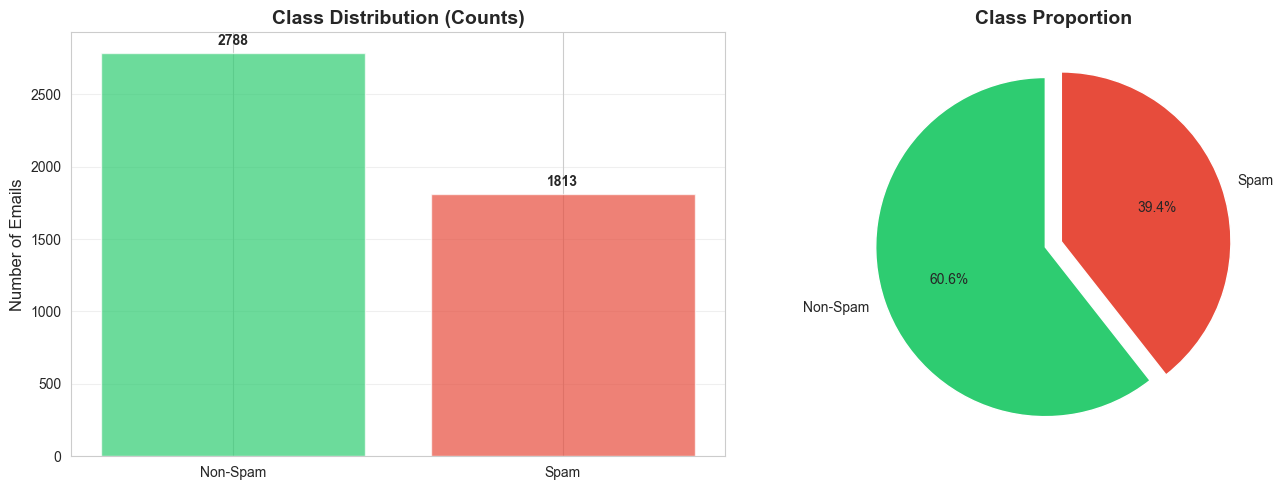


INTUITION:
Class imbalance ratio: 1.54:1 (non-spam to spam)
✓ Dataset is relatively balanced - standard metrics should work well.


In [3]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
missing_count = data.isnull().sum().sum()
print(f"\nTotal missing values: {missing_count}")
print(f"Percentage of missing values: {(missing_count / data.size) * 100:.2f}%")

if missing_count > 0:
    print("\nColumns with missing values:")
    print(data.isnull().sum()[data.isnull().sum() > 0])
else:
    print("\nNo missing values found - dataset is complete!")

# Check class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)
class_counts = data['type'].value_counts()
class_proportions = data['type'].value_counts(normalize=True)

print(f"\nClass counts:")
print(f"  Non-spam (0): {class_counts[0]} emails ({class_proportions[0]:.2%})")
print(f"  Spam (1):     {class_counts[1]} emails ({class_proportions[1]:.2%})")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Non-Spam', 'Spam'], class_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Number of Emails', fontsize=12)
axes[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Proportion plot
axes[1].pie(class_counts.values, labels=['Non-Spam', 'Spam'], autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0.05))
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION:")
print("=" * 60)
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1 (non-spam to spam)")
if imbalance_ratio > 2 or imbalance_ratio < 0.5:
    print("⚠ Dataset is imbalanced! Consider using:")
    print("  - Stratified sampling during train-test split")
    print("  - Class weights in models")
    print("  - F1-score as primary metric (balances precision & recall)")
else:
    print("✓ Dataset is relatively balanced - standard metrics should work well.")

### B. Outlier Detection & Decision Tree Consideration

**Goal:** Identify outliers and understand their impact on model choice

OUTLIER DETECTION (IQR Method)

Columns with outliers: 57 out of 57

Top 10 columns with most outliers:
  hp: 1090 outliers (23.69%)
  make: 1053 outliers (22.89%)
  email: 1038 outliers (22.56%)
  re: 1001 outliers (21.76%)
  over: 999 outliers (21.71%)
  business: 963 outliers (20.93%)
  free: 957 outliers (20.80%)
  address: 898 outliers (19.52%)
  mail: 852 outliers (18.52%)
  people: 852 outliers (18.52%)


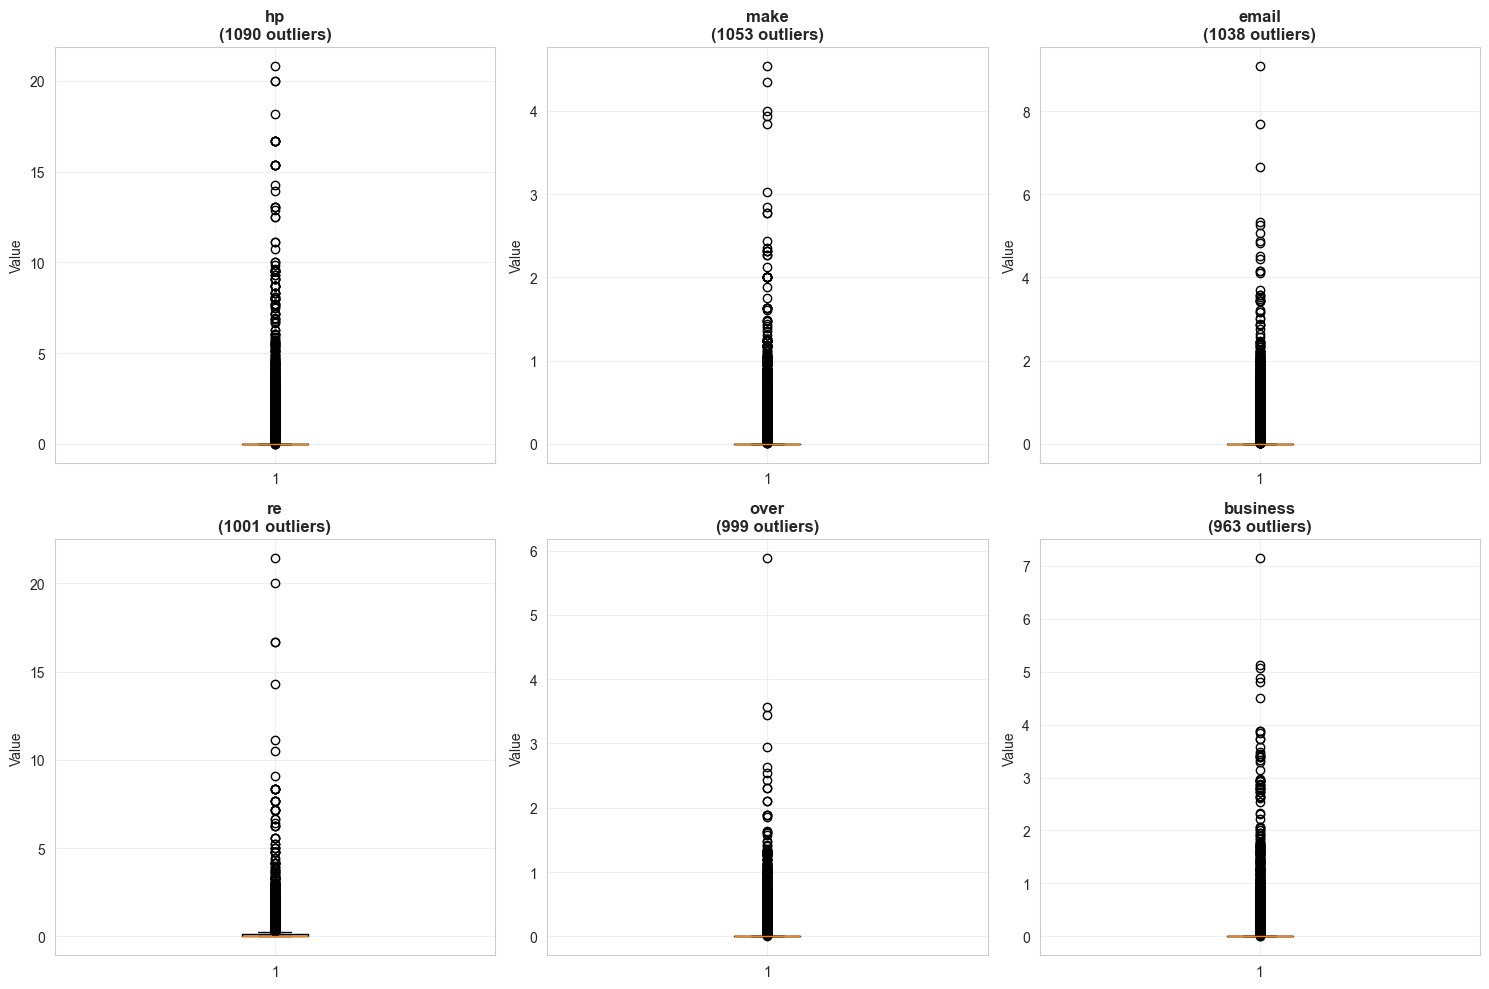


DECISION TREE & OUTLIERS: KEY INSIGHTS

✓ DECISION TREES ARE ROBUST TO OUTLIERS!

Reasons:
1. Tree-based models use RANK-BASED SPLITS (thresholds), not distances
   - They only care about "is value > threshold?" not the actual magnitude
   - An outlier of 1000 vs 100 doesn't matter if split threshold is 50

2. ISOLATION: Outliers often end up in their own leaf nodes
   - They get separated naturally during recursive splitting
   - This actually helps classify them correctly if they're valid data points

3. NO SCALE DEPENDENCY: Unlike distance-based models (KNN, SVM, Neural Nets)
   - Decision trees don't compute Euclidean distances
   - No need for feature scaling or outlier removal

RECOMMENDATION FOR THIS DATASET:
→ DO NOT remove outliers for Decision Tree classifier
→ High word frequencies might indicate spam (e.g., "free" appears 50 times)
→ These outliers carry IMPORTANT INFORMATION for classification

However, for Logistic Regression:
→ CONSIDER standardization (but not outlier 

In [4]:
# Identify outliers using IQR method
X = data.drop('type', axis=1)
y = data['type']

print("=" * 60)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 60)

# Calculate outliers for each feature
outlier_columns = []
outlier_stats = {}

for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    
    if outliers > 0:
        outlier_columns.append(col)
        outlier_stats[col] = {
            'count': outliers,
            'percentage': (outliers / len(X)) * 100
        }

print(f"\nColumns with outliers: {len(outlier_columns)} out of {len(X.columns)}")
print(f"\nTop 10 columns with most outliers:")
sorted_outliers = sorted(outlier_stats.items(), key=lambda x: x[1]['count'], reverse=True)[:10]
for col, stats in sorted_outliers:
    print(f"  {col}: {stats['count']} outliers ({stats['percentage']:.2f}%)")

# Visualize outliers for top features
if len(outlier_columns) > 0:
    top_outlier_cols = [item[0] for item in sorted_outliers[:6]]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_outlier_cols):
        axes[idx].boxplot(X[col], vert=True)
        axes[idx].set_title(f'{col}\n({outlier_stats[col]["count"]} outliers)', fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 60)
print("DECISION TREE & OUTLIERS: KEY INSIGHTS")
print("=" * 60)
print("""
✓ DECISION TREES ARE ROBUST TO OUTLIERS!

Reasons:
1. Tree-based models use RANK-BASED SPLITS (thresholds), not distances
   - They only care about "is value > threshold?" not the actual magnitude
   - An outlier of 1000 vs 100 doesn't matter if split threshold is 50

2. ISOLATION: Outliers often end up in their own leaf nodes
   - They get separated naturally during recursive splitting
   - This actually helps classify them correctly if they're valid data points

3. NO SCALE DEPENDENCY: Unlike distance-based models (KNN, SVM, Neural Nets)
   - Decision trees don't compute Euclidean distances
   - No need for feature scaling or outlier removal

RECOMMENDATION FOR THIS DATASET:
→ DO NOT remove outliers for Decision Tree classifier
→ High word frequencies might indicate spam (e.g., "free" appears 50 times)
→ These outliers carry IMPORTANT INFORMATION for classification

However, for Logistic Regression:
→ CONSIDER standardization (but not outlier removal)
→ Logistic regression uses weighted sums - extreme values can dominate
→ Standardization helps but doesn't remove the information
""")

### C. Check and Remove Duplicates

**Goal:** Ensure data integrity by removing duplicate emails

In [5]:
# Check for duplicate emails
print("=" * 60)
print("DUPLICATE EMAIL DETECTION")
print("=" * 60)

original_size = len(data)
duplicate_count = data.duplicated().sum()

print(f"\nOriginal dataset size: {original_size} emails")
print(f"Duplicate emails found: {duplicate_count}")

if duplicate_count > 0:
    print(f"Percentage of duplicates: {(duplicate_count / original_size) * 100:.2f}%")
    
    # Check if duplicates have same labels
    duplicate_rows = data[data.duplicated(keep=False)]
    print(f"\nAnalyzing {len(duplicate_rows)} rows involved in duplication...")
    
    # Drop duplicates
    data_cleaned = data.drop_duplicates()
    print(f"\n✓ Duplicates removed!")
    print(f"New dataset size: {len(data_cleaned)} emails")
    print(f"Emails removed: {original_size - len(data_cleaned)}")
    
    # Update X and y
    X = data_cleaned.drop('type', axis=1)
    y = data_cleaned['type']
    
else:
    print("\n✓ No duplicate emails found - dataset is clean!")
    data_cleaned = data

print("\n" + "=" * 60)
print("INTUITION:")
print("=" * 60)
print("""
Why remove duplicates?
1. PREVENT DATA LEAKAGE: Same email shouldn't appear in both train & test
2. AVOID OVERFITTING: Model shouldn't memorize repeated patterns
3. FAIR EVALUATION: Duplicates inflate performance metrics artificially
4. REALISTIC PERFORMANCE: We want to predict on truly unseen emails
""")

DUPLICATE EMAIL DETECTION

Original dataset size: 4601 emails
Duplicate emails found: 391
Percentage of duplicates: 8.50%

Analyzing 571 rows involved in duplication...

✓ Duplicates removed!
New dataset size: 4210 emails
Emails removed: 391

INTUITION:

Why remove duplicates?
1. PREVENT DATA LEAKAGE: Same email shouldn't appear in both train & test
2. AVOID OVERFITTING: Model shouldn't memorize repeated patterns
3. FAIR EVALUATION: Duplicates inflate performance metrics artificially
4. REALISTIC PERFORMANCE: We want to predict on truly unseen emails



### D. Train-Test Split

**Goal:** Split data properly to evaluate model on unseen emails

In [6]:
# Split data into training and testing sets
# Use stratify to maintain class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42,  # For reproducibility
    stratify=y  # Maintain spam/non-spam ratio
)

print("=" * 60)
print("TRAIN-TEST SPLIT SUMMARY")
print("=" * 60)
print(f"\nTotal samples: {len(X)}")
print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Non-spam: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  - Spam:     {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nTest set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Non-spam: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  - Spam:     {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

print("\n" + "=" * 60)
print("INTUITION:")
print("=" * 60)
print("""
✓ 80-20 split is standard: enough data to train, enough to test reliably
✓ Stratification ensures both sets have same spam/non-spam ratio
✓ Random state = 42 makes results reproducible (same split every time)
✓ Test set simulates "unseen emails" the model will face in production
""")

TRAIN-TEST SPLIT SUMMARY

Total samples: 4210

Training set: 3368 samples (80.0%)
  - Non-spam: 0 (0.0%)
  - Spam:     0 (0.0%)

Test set: 842 samples (20.0%)
  - Non-spam: 0 (0.0%)
  - Spam:     0 (0.0%)

INTUITION:

✓ 80-20 split is standard: enough data to train, enough to test reliably
✓ Stratification ensures both sets have same spam/non-spam ratio
✓ Random state = 42 makes results reproducible (same split every time)
✓ Test set simulates "unseen emails" the model will face in production



### E. Model Training & Hyperparameter Tuning

**Goal:** Build interpretable models (Logistic Regression & Decision Tree) with optimized hyperparameters

We'll use GridSearchCV for systematic hyperparameter tuning.

In [7]:
# First, let's standardize features for Logistic Regression
# (Decision Tree doesn't need scaling, but LR benefits from it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION with GridSearchCV")
print("=" * 60)

# Define parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear'],  # Solver that supports both L1 and L2
    'max_iter': [1000]  # Maximum iterations
}

# Initialize Logistic Regression
lr_base = LogisticRegression(random_state=42)

# GridSearchCV with 5-fold cross-validation
lr_grid = GridSearchCV(
    lr_base, 
    lr_param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  # Optimize for F1 score (balances precision and recall)
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit the model
print("\nTraining Logistic Regression with hyperparameter tuning...")
lr_grid.fit(X_train_scaled, y_train)

print(f"\n✓ Training complete!")
print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best cross-validation F1 score: {lr_grid.best_score_:.4f}")

# Get the best model
best_lr = lr_grid.best_estimator_

print("\n" + "=" * 60)
print("INTUITION - Logistic Regression Parameters:")
print("=" * 60)
print(f"""
C (Regularization): {lr_grid.best_params_['C']}
  - HIGHER C = Less regularization = More complex model (might overfit)
  - LOWER C = More regularization = Simpler model (prevents overfitting)
  - Best C balances bias-variance tradeoff

Penalty: {lr_grid.best_params_['penalty']}
  - L1 (Lasso): Drives some coefficients to ZERO → Feature selection
  - L2 (Ridge): Shrinks all coefficients → Keeps all features
  - {'L1 selected sparse features!' if lr_grid.best_params_['penalty'] == 'l1' else 'L2 uses all features with controlled weights'}
""")

MODEL 1: LOGISTIC REGRESSION with GridSearchCV

Training Logistic Regression with hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✓ Training complete!

Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.9205

INTUITION - Logistic Regression Parameters:

C (Regularization): 1
  - HIGHER C = Less regularization = More complex model (might overfit)
  - LOWER C = More regularization = Simpler model (prevents overfitting)
  - Best C balances bias-variance tradeoff

Penalty: l1
  - L1 (Lasso): Drives some coefficients to ZERO → Feature selection
  - L2 (Ridge): Shrinks all coefficients → Keeps all features
  - L1 selected sparse features!



#### Mathematical Foundation: Logistic Regression

**Logistic Regression Model:**

The logistic regression model predicts the probability of spam using the sigmoid function:

$$P(y=1|x) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

where the linear combination is:

$$z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n = \beta^T x$$

**Log-Odds (Logit):**

$$\log\left(\frac{P(spam)}{P(non\text{-}spam)}\right) = \beta^T x$$

**Cost Function (Binary Cross-Entropy):**

$$J(\beta) = -\frac{1}{m}\sum_{i=1}^{m}\left[y^{(i)}\log(h_\beta(x^{(i)})) + (1-y^{(i)})\log(1-h_\beta(x^{(i)}))\right]$$

**Regularization:**

- **L1 (Lasso):** $J(\beta) + \lambda \sum_{j=1}^{n}|\beta_j|$ → Sparse solutions (feature selection)
- **L2 (Ridge):** $J(\beta) + \lambda \sum_{j=1}^{n}\beta_j^2$ → Small weights (all features retained)

where $\lambda = \frac{1}{C}$ (inverse of C parameter in sklearn)

In [8]:
print("=" * 60)
print("MODEL 2: DECISION TREE with GridSearchCV")
print("=" * 60)

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],  # Tree depth
    'min_samples_split': [2, 5, 10, 20],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],  # Min samples in a leaf
    'criterion': ['gini', 'entropy']  # Split criterion
}

# Initialize Decision Tree
dt_base = DecisionTreeClassifier(random_state=42)

# GridSearchCV
dt_grid = GridSearchCV(
    dt_base,
    dt_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit the model (Decision Tree doesn't need scaled data)
print("\nTraining Decision Tree with hyperparameter tuning...")
dt_grid.fit(X_train, y_train)

print(f"\n✓ Training complete!")
print(f"\nBest parameters: {dt_grid.best_params_}")
print(f"Best cross-validation F1 score: {dt_grid.best_score_:.4f}")

# Get the best model
best_dt = dt_grid.best_estimator_

print("\n" + "=" * 60)
print("INTUITION - Decision Tree Parameters:")
print("=" * 60)
print(f"""
Max Depth: {dt_grid.best_params_['max_depth']}
  - Controls tree complexity (how many questions can be asked)
  - Deeper = More complex patterns but risk overfitting
  - Shallower = Simpler, more generalizable
  - {f'Depth of {dt_grid.best_params_["max_depth"]} means at most {dt_grid.best_params_["max_depth"]} sequential decisions' if dt_grid.best_params_['max_depth'] else 'No limit - tree grows until pure'}

Min Samples Split: {dt_grid.best_params_['min_samples_split']}
  - Minimum emails needed to create a new split
  - Higher value = More conservative splitting = Prevents overfitting
  - Forces tree to generalize better

Min Samples Leaf: {dt_grid.best_params_['min_samples_leaf']}
  - Minimum emails that must end up in each leaf node
  - Prevents tiny leaves with just a few samples
  - Helps avoid memorizing noise

Criterion: {dt_grid.best_params_['criterion']}
  - {'Gini: Measures impurity - faster to compute' if dt_grid.best_params_['criterion'] == 'gini' else 'Entropy: Information gain - more theoretically grounded'}
  - Both usually give similar results
""")

MODEL 2: DECISION TREE with GridSearchCV

Training Decision Tree with hyperparameter tuning...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

✓ Training complete!

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
Best cross-validation F1 score: 0.9180

INTUITION - Decision Tree Parameters:

Max Depth: None
  - Controls tree complexity (how many questions can be asked)
  - Deeper = More complex patterns but risk overfitting
  - Shallower = Simpler, more generalizable
  - No limit - tree grows until pure

Min Samples Split: 20
  - Minimum emails needed to create a new split
  - Higher value = More conservative splitting = Prevents overfitting
  - Forces tree to generalize better

Min Samples Leaf: 2
  - Minimum emails that must end up in each leaf node
  - Prevents tiny leaves with just a few samples
  - Helps avoid memorizing noise

Criterion: entropy
  - Entropy: Information gain - more theoretically grounded


#### Mathematical Foundation: Decision Trees

**Gini Impurity:**

$$Gini(t) = 1 - \sum_{i=1}^{C} p_i^2$$

where $p_i$ is the proportion of class $i$ at node $t$, and $C$ is the number of classes.

**Information Gain (Entropy):**

$$Entropy(t) = -\sum_{i=1}^{C} p_i \log_2(p_i)$$

**Information Gain from Split:**

$$IG(parent, children) = Entropy(parent) - \sum_{child} \frac{n_{child}}{n_{parent}} \cdot Entropy(child)$$

**Split Decision:**

At each node, find feature $j$ and threshold $\tau$ that maximizes:

$$IG(j, \tau) = Impurity(parent) - \frac{n_{left}}{n_{total}}Impurity(left) - \frac{n_{right}}{n_{total}}Impurity(right)$$

**Key Properties:**
- Lower impurity = purer node (better separation)
- Trees split recursively to minimize impurity
- Stopping criteria: max_depth, min_samples_split, min_samples_leaf

### F. Model Evaluation on Test Data

**Goal:** Assess model performance on unseen emails using comprehensive metrics

#### Mathematical Foundation: Classification Metrics

Given a confusion matrix with True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN):

**Accuracy:**

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Proportion of correct predictions overall.

**Precision:**

$$Precision = \frac{TP}{TP + FP}$$

Of all items predicted as positive (spam), what proportion is actually positive?

**Recall (Sensitivity):**

$$Recall = \frac{TP}{TP + FN}$$

Of all actual positive items (spam), what proportion did we detect?

**F1 Score:**

$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} = \frac{2TP}{2TP + FP + FN}$$

Harmonic mean of precision and recall (balanced metric).

**Why Harmonic Mean?**
- Arithmetic mean: $\frac{P + R}{2}$ would give high score even if one metric is low
- Harmonic mean: penalizes extreme imbalance, requires both P and R to be high

LOGISTIC REGRESSION - TEST SET PERFORMANCE

Accuracy:  0.9371 (93.71%)
Precision: 0.9301 (93.01%)
Recall:    0.9107 (91.07%)
F1 Score:  0.9203 (92.03%)

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     nonspam       0.94      0.95      0.95       506
        spam       0.93      0.91      0.92       336

    accuracy                           0.94       842
   macro avg       0.94      0.93      0.93       842
weighted avg       0.94      0.94      0.94       842

DECISION TREE - TEST SET PERFORMANCE

Accuracy:  0.9145 (91.45%)
Precision: 0.8952 (89.52%)
Recall:    0.8899 (88.99%)
F1 Score:  0.8925 (89.25%)

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     nonspam       0.93     

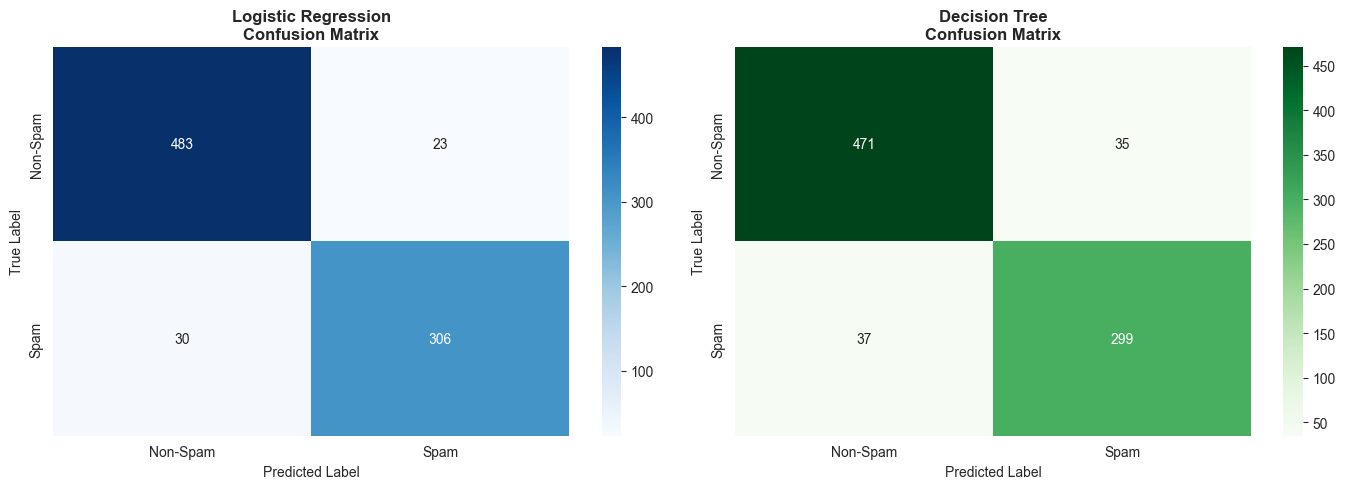


MODEL COMPARISON
   Metric  Logistic Regression  Decision Tree
 Accuracy             0.937055       0.914489
Precision             0.930091       0.895210
   Recall             0.910714       0.889881
 F1 Score             0.920301       0.892537

🏆 Best Model: Logistic Regression (F1 Score: 0.9203)

INTUITION - Understanding the Metrics:

ACCURACY: Overall correctness (but misleading if classes imbalanced)
  → What % of ALL predictions were correct?

PRECISION: When model predicts SPAM, how often is it right?
  → Precision = TP / (TP + FP)
  → HIGH precision = Few false alarms (non-spam marked as spam)
  → Important when false positives are costly (missing important emails)

RECALL: Of all ACTUAL spam, how much did we catch?
  → Recall = TP / (TP + FN)
  → HIGH recall = Catches most spam (few spam emails slip through)
  → Important when false negatives are costly (spam reaching inbox)

F1 SCORE: Harmonic mean of Precision & Recall
  → Balances both - best single metric for spam detec

In [9]:
# Make predictions on test set
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_dt = best_dt.predict(X_test)

# Calculate metrics for both models
def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    print("=" * 60)
    print(f"{model_name} - TEST SET PERFORMANCE")
    print("=" * 60)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='spam')
    recall = recall_score(y_true, y_pred, pos_label='spam')
    f1 = f1_score(y_true, y_pred, pos_label='spam')
    
    print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1 Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    print("\n" + "-" * 60)
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=['nonspam', 'spam']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return accuracy, precision, recall, f1, cm

# Evaluate both models
lr_metrics = evaluate_model(y_test, y_pred_lr, "LOGISTIC REGRESSION")
dt_metrics = evaluate_model(y_test, y_pred_dt, "DECISION TREE")

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression Confusion Matrix
sns.heatmap(lr_metrics[4], annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Decision Tree Confusion Matrix
sns.heatmap(dt_metrics[4], annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
axes[1].set_title('Decision Tree\nConfusion Matrix', fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Compare models
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression': [lr_metrics[0], lr_metrics[1], lr_metrics[2], lr_metrics[3]],
    'Decision Tree': [dt_metrics[0], dt_metrics[1], dt_metrics[2], dt_metrics[3]]
})
print(comparison_df.to_string(index=False))

# Determine best model
best_model_name = "Logistic Regression" if lr_metrics[3] > dt_metrics[3] else "Decision Tree"
best_model = best_lr if lr_metrics[3] > dt_metrics[3] else best_dt
best_f1 = max(lr_metrics[3], dt_metrics[3])

print(f"\n🏆 Best Model: {best_model_name} (F1 Score: {best_f1:.4f})")

print("\n" + "=" * 60)
print("INTUITION - Understanding the Metrics:")
print("=" * 60)
print("""
ACCURACY: Overall correctness (but misleading if classes imbalanced)
  → What % of ALL predictions were correct?

PRECISION: When model predicts SPAM, how often is it right?
  → Precision = TP / (TP + FP)
  → HIGH precision = Few false alarms (non-spam marked as spam)
  → Important when false positives are costly (missing important emails)

RECALL: Of all ACTUAL spam, how much did we catch?
  → Recall = TP / (TP + FN)
  → HIGH recall = Catches most spam (few spam emails slip through)
  → Important when false negatives are costly (spam reaching inbox)

F1 SCORE: Harmonic mean of Precision & Recall
  → Balances both - best single metric for spam detection
  → Perfect balance: catch spam without blocking legitimate emails

For SPAM DETECTION:
  - We want HIGH RECALL (catch most spam)
  - But also GOOD PRECISION (don't block important emails)
  - F1 Score is the best overall indicator!
""")

### G. Model Interpretation

**Goal:** Understand HOW and WHY the model makes predictions

#### G1. Logistic Regression - Coefficient Interpretation

LOGISTIC REGRESSION - COEFFICIENT INTERPRETATION

🚨 TOP 15 SPAM INDICATORS (Positive Coefficients):
------------------------------------------------------------
  charDollar          : +1.2127
  capitalLong         : +1.1531
  num3d               : +1.0731
  remove              : +1.0421
  charHash            : +0.8237
  free                : +0.7591
  num000              : +0.7086
  capitalTotal        : +0.5141
  addresses           : +0.4217
  business            : +0.3766
  charExclamation     : +0.3182
  technology          : +0.3120
  our                 : +0.3017
  your                : +0.2953
  font                : +0.2936

✅ TOP 15 NON-SPAM INDICATORS (Negative Coefficients):
------------------------------------------------------------
  charSemicolon       : -0.3654
  num1999             : -0.3627
  original            : -0.3029
  pm                  : -0.3025
  table               : -0.1865
  parts               : -0.1453
  labs                : -0.1009
  will             

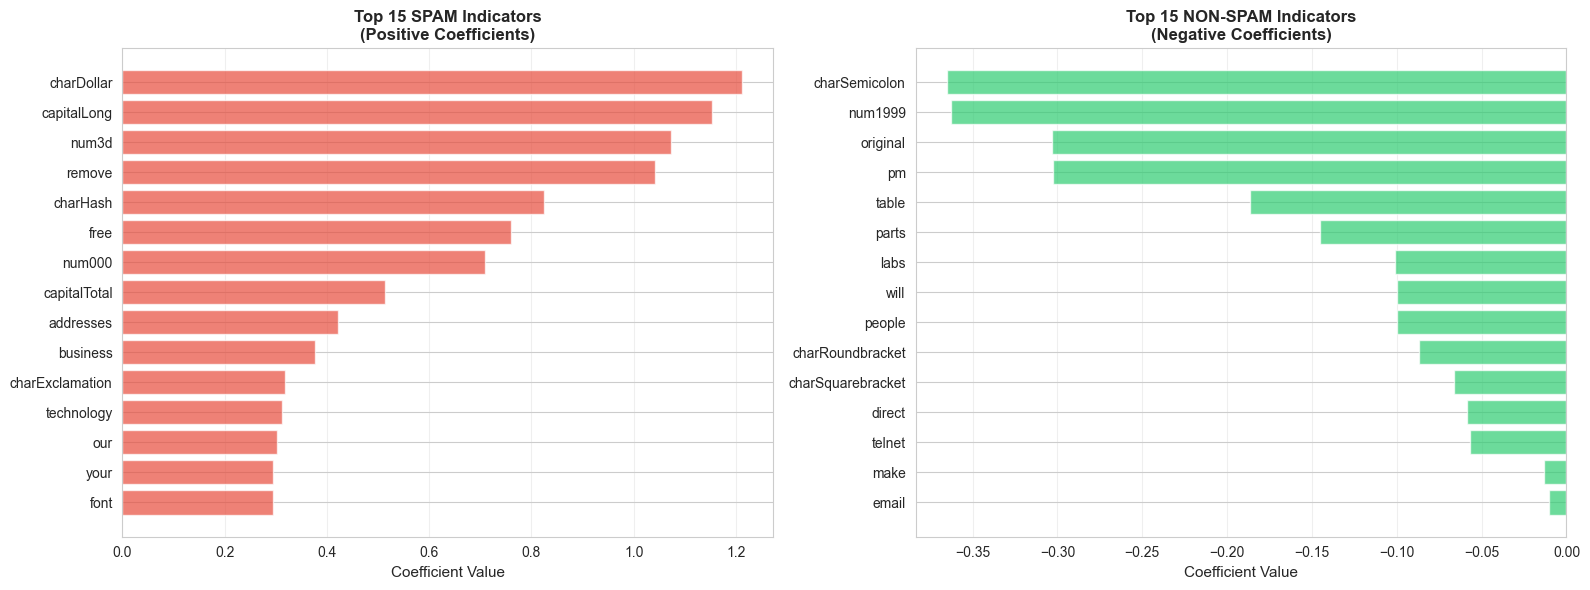


INTUITION - How to Read Coefficients:

Logistic Regression Model: log(P(spam)/P(non-spam)) = β₀ + β₁x₁ + β₂x₂ + ...

POSITIVE Coefficient (β > 0):
  → Increases log-odds of being SPAM
  → The higher the coefficient, the stronger the spam signal
  → Example: If "free" has coefficient +2.5:
     - Each occurrence of "free" multiplies spam odds by e^2.5 ≈ 12.2x
     - Word "free" appearing frequently screams SPAM!

NEGATIVE Coefficient (β < 0):
  → Decreases log-odds of being SPAM (indicates non-spam)
  → The more negative, the stronger the non-spam signal
  → Example: If "meeting" has coefficient -1.8:
     - Each "meeting" divides spam odds by e^1.8 ≈ 6x
     - Professional words indicate legitimate business emails

MAGNITUDE Matters:
  → Larger |coefficient| = Stronger influence on prediction
  → Small coefficients ≈ negligible impact

HUMAN INTUITION CHECK:
  - Do spam indicators match what YOU'D expect? (free, money, click, !!!)
  - Do non-spam indicators look like professional comm

In [10]:
# Interpret Logistic Regression coefficients
print("=" * 60)
print("LOGISTIC REGRESSION - COEFFICIENT INTERPRETATION")
print("=" * 60)

# Get coefficients
coefficients = best_lr.coef_[0]
feature_names = X.columns

# Create DataFrame for better visualization
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Top words indicating SPAM (positive coefficients)
print("\n🚨 TOP 15 SPAM INDICATORS (Positive Coefficients):")
print("-" * 60)
spam_indicators = coef_df[coef_df['Coefficient'] > 0].head(15)
for idx, row in spam_indicators.iterrows():
    print(f"  {row['Feature']:20s}: {row['Coefficient']:+.4f}")

# Top words indicating NON-SPAM (negative coefficients)
print("\n✅ TOP 15 NON-SPAM INDICATORS (Negative Coefficients):")
print("-" * 60)
nonspam_indicators = coef_df[coef_df['Coefficient'] < 0].tail(15)
for idx, row in nonspam_indicators.iterrows():
    print(f"  {row['Feature']:20s}: {row['Coefficient']:+.4f}")

# Visualize top coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top spam indicators
top_spam = coef_df[coef_df['Coefficient'] > 0].head(15)
axes[0].barh(range(len(top_spam)), top_spam['Coefficient'], color='#e74c3c', alpha=0.7)
axes[0].set_yticks(range(len(top_spam)))
axes[0].set_yticklabels(top_spam['Feature'])
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_title('Top 15 SPAM Indicators\n(Positive Coefficients)', fontweight='bold', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top non-spam indicators
top_nonspam = coef_df[coef_df['Coefficient'] < 0].tail(15)
axes[1].barh(range(len(top_nonspam)), top_nonspam['Coefficient'], color='#2ecc71', alpha=0.7)
axes[1].set_yticks(range(len(top_nonspam)))
axes[1].set_yticklabels(top_nonspam['Feature'])
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('Top 15 NON-SPAM Indicators\n(Negative Coefficients)', fontweight='bold', fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION - How to Read Coefficients:")
print("=" * 60)
print("""
Logistic Regression Model: log(P(spam)/P(non-spam)) = β₀ + β₁x₁ + β₂x₂ + ...

POSITIVE Coefficient (β > 0):
  → Increases log-odds of being SPAM
  → The higher the coefficient, the stronger the spam signal
  → Example: If "free" has coefficient +2.5:
     - Each occurrence of "free" multiplies spam odds by e^2.5 ≈ 12.2x
     - Word "free" appearing frequently screams SPAM!

NEGATIVE Coefficient (β < 0):
  → Decreases log-odds of being SPAM (indicates non-spam)
  → The more negative, the stronger the non-spam signal
  → Example: If "meeting" has coefficient -1.8:
     - Each "meeting" divides spam odds by e^1.8 ≈ 6x
     - Professional words indicate legitimate business emails

MAGNITUDE Matters:
  → Larger |coefficient| = Stronger influence on prediction
  → Small coefficients ≈ negligible impact

HUMAN INTUITION CHECK:
  - Do spam indicators match what YOU'D expect? (free, money, click, !!!)
  - Do non-spam indicators look like professional communication?
  - If coefficients seem random → model might be overfitting
""")

#### G2. Decision Tree - Tree Structure Interpretation

For decision trees, we'll visualize the tree structure to understand the decision-making process.

DECISION TREE - STRUCTURE INTERPRETATION

Tree Depth: 23
Number of Leaves: 114
Number of Nodes: 227

📊 TOP 15 MOST IMPORTANT FEATURES:
------------------------------------------------------------
  charDollar          : 0.2787
  remove              : 0.1453
  charExclamation     : 0.1064
  hp                  : 0.0771
  capitalLong         : 0.0467
  free                : 0.0465
  capitalTotal        : 0.0437
  edu                 : 0.0435
  george              : 0.0386
  capitalAve          : 0.0201
  re                  : 0.0184
  you                 : 0.0182
  our                 : 0.0175
  your                : 0.0157
  num1999             : 0.0090


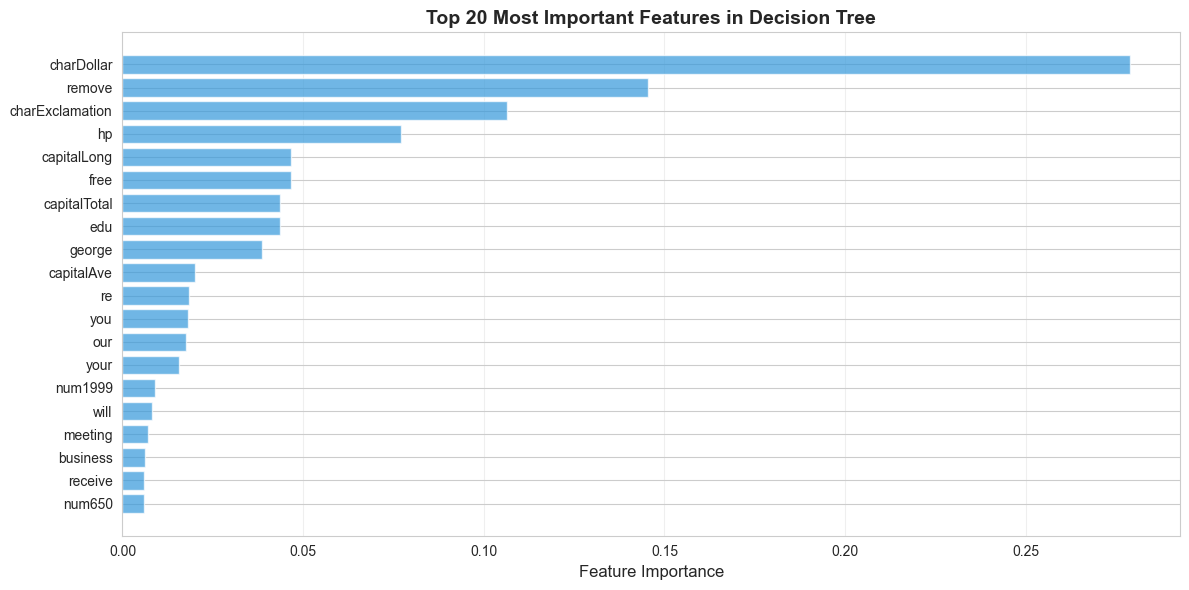

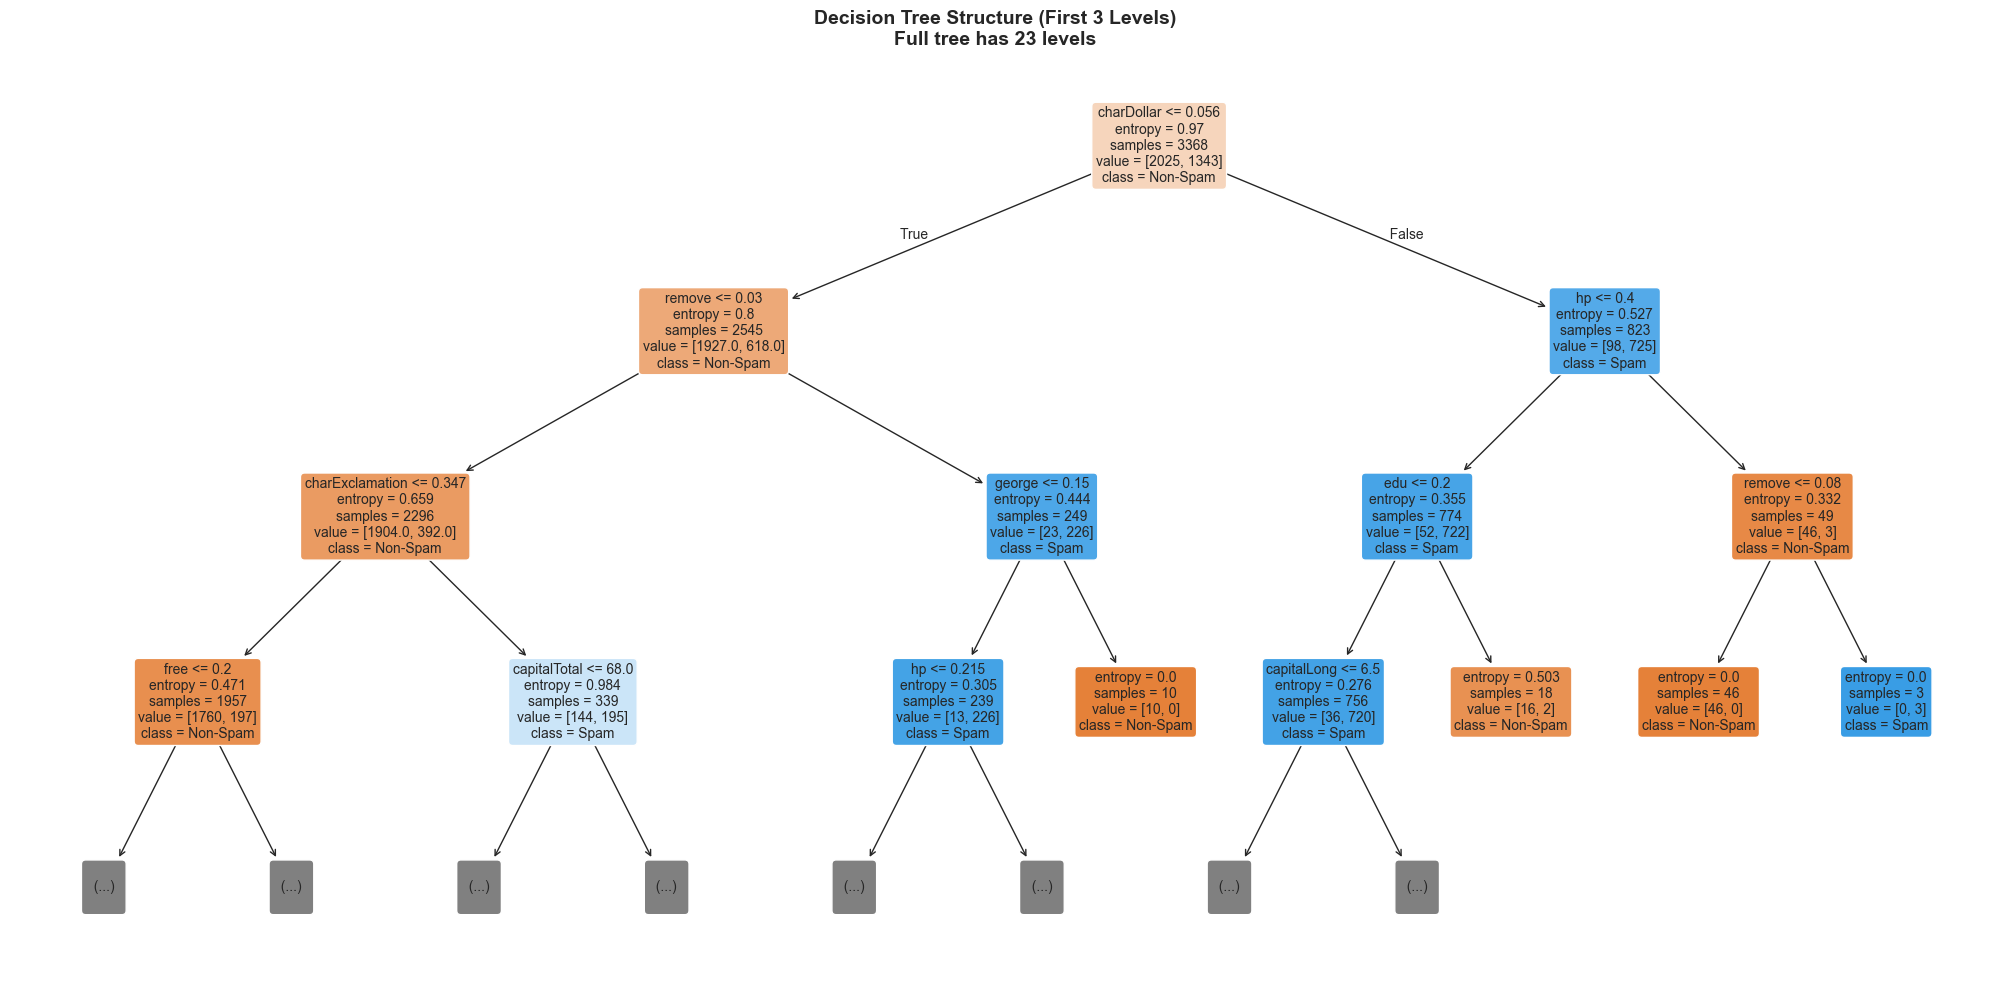


INTUITION - Understanding Decision Trees:

FEATURE IMPORTANCE:
  → Measures how much each feature contributes to splitting decisions
  → Higher importance = Feature is used more often and creates better splits
  → Sum of all importances = 1.0 (100%)

HOW TO READ THE TREE:
  1. START at ROOT (top): Most important feature split
  2. Each NODE asks: "Is [feature] ≤ [threshold]?"
     - YES (left branch) → Go left
     - NO (right branch) → Go right
  3. LEAF NODES (bottom): Final prediction
     - Color intensity shows confidence
     - Value = [non-spam count, spam count]

EXAMPLE PATH (hypothetical):
  Root: "Is 'remove' ≤ 0.5?"  → If NO (word appears)
    ↓
  Next: "Is 'free' ≤ 2.5?"    → If NO (appears 3+ times)
    ↓
  Leaf: SPAM! (98% confidence)

KEY INSIGHT:
  The most important features at the top of the tree are the PRIMARY
  decision-makers. These are the words that best separate spam from non-spam.

  Unlike Logistic Regression (which weighs ALL features), Decision Trees
  cr

In [11]:
# Visualize Decision Tree structure
from sklearn.tree import plot_tree

print("=" * 60)
print("DECISION TREE - STRUCTURE INTERPRETATION")
print("=" * 60)

# Get tree information
print(f"\nTree Depth: {best_dt.get_depth()}")
print(f"Number of Leaves: {best_dt.get_n_leaves()}")
print(f"Number of Nodes: {best_dt.tree_.node_count}")

# Feature importance
feature_importance = best_dt.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 15 MOST IMPORTANT FEATURES:")
print("-" * 60)
for idx, row in importance_df.head(15).iterrows():
    print(f"  {row['Feature']:20s}: {row['Importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='#3498db', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Most Important Features in Decision Tree', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the decision tree (simplified version for interpretability)
# We'll limit depth for visualization
plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          max_depth=3,  # Show only first 3 levels for clarity
          feature_names=feature_names,
          class_names=['Non-Spam', 'Spam'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f'Decision Tree Structure (First 3 Levels)\nFull tree has {best_dt.get_depth()} levels', 
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION - Understanding Decision Trees:")
print("=" * 60)
print(f"""
FEATURE IMPORTANCE:
  → Measures how much each feature contributes to splitting decisions
  → Higher importance = Feature is used more often and creates better splits
  → Sum of all importances = 1.0 (100%)

HOW TO READ THE TREE:
  1. START at ROOT (top): Most important feature split
  2. Each NODE asks: "Is [feature] ≤ [threshold]?"
     - YES (left branch) → Go left
     - NO (right branch) → Go right
  3. LEAF NODES (bottom): Final prediction
     - Color intensity shows confidence
     - Value = [non-spam count, spam count]

EXAMPLE PATH (hypothetical):
  Root: "Is 'remove' ≤ 0.5?"  → If NO (word appears)
    ↓
  Next: "Is 'free' ≤ 2.5?"    → If NO (appears 3+ times)
    ↓
  Leaf: SPAM! (98% confidence)

KEY INSIGHT:
  The most important features at the top of the tree are the PRIMARY
  decision-makers. These are the words that best separate spam from non-spam.
  
  Unlike Logistic Regression (which weighs ALL features), Decision Trees
  create a HIERARCHY of decisions - some features never even get checked
  if earlier splits already provide clear classification.
""")

### H. Save the Best Model

**Goal:** Save the trained model for future use in production

In [12]:
# Save the best model and scaler
print("=" * 60)
print("SAVING MODELS")
print("=" * 60)

# Save best model
model_filename = f'best_spam_filter_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"\n✓ Best model saved: {model_filename}")
print(f"  Model: {best_model_name}")
print(f"  F1 Score: {best_f1:.4f}")

# Also save the scaler if Logistic Regression was best
if best_model_name == "Logistic Regression":
    scaler_filename = 'spam_filter_scaler.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"\n✓ Scaler saved: {scaler_filename}")
    print("  (Required for preprocessing new emails before prediction)")

# Save both models for comparison
joblib.dump(best_lr, 'spam_filter_logistic_regression.pkl')
joblib.dump(best_dt, 'spam_filter_decision_tree.pkl')
joblib.dump(scaler, 'spam_filter_scaler.pkl')
print(f"\n✓ All models saved for future comparison:")
print("  - spam_filter_logistic_regression.pkl")
print("  - spam_filter_decision_tree.pkl")
print("  - spam_filter_scaler.pkl")

# Demonstrate how to load and use the model
print("\n" + "=" * 60)
print("HOW TO USE THE SAVED MODEL:")
print("=" * 60)
# print("""
# # Load the model
# import joblib
# model = joblib.load('best_spam_filter_*.pkl')

# # For Logistic Regression, also load scaler:
# scaler = joblib.load('spam_filter_scaler.pkl')

# # Prepare new email (same features as training data)
# new_email = [...]  # Feature vector

# # Make prediction
# if model_name == "Logistic Regression":
#     new_email_scaled = scaler.transform([new_email])
#     prediction = model.predict(new_email_scaled)
# else:  # Decision Tree
#     prediction = model.predict([new_email])

# # Result: 0 = Non-Spam, 1 = Spam
# """

print("\n✅ Task 1 Complete! Best spam filter trained and saved.")
print(f"   Performance: {best_f1*100:.2f}% F1 Score on unseen emails")

SAVING MODELS

✓ Best model saved: best_spam_filter_logistic_regression.pkl
  Model: Logistic Regression
  F1 Score: 0.9203

✓ Scaler saved: spam_filter_scaler.pkl
  (Required for preprocessing new emails before prediction)

✓ All models saved for future comparison:
  - spam_filter_logistic_regression.pkl
  - spam_filter_decision_tree.pkl
  - spam_filter_scaler.pkl

HOW TO USE THE SAVED MODEL:

✅ Task 1 Complete! Best spam filter trained and saved.
   Performance: 92.03% F1 Score on unseen emails


---
---
## Task 2: Fashion MNIST Dataset

**Objective:** Classify fashion items (10 classes) using interpretable models

Fashion-MNIST: 70,000 grayscale images (28×28 pixels) of clothing items
- Training: 60,000 images
- Testing: 10,000 images
- Classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

### A. Load and Preprocess Fashion MNIST Data

In [13]:
# Import additional libraries for Fashion MNIST
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
import time

print("=" * 60)
print("LOADING FASHION MNIST DATASET")
print("=" * 60)
print("\nThis may take a few moments on first load (downloads ~30MB)...")

# Load Fashion MNIST dataset
start_time = time.time()
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, parser='auto')
load_time = time.time() - start_time

print(f"✓ Dataset loaded in {load_time:.2f} seconds")

# Extract features and labels
X_fashion = fashion_mnist.data
y_fashion = fashion_mnist.target.astype(int)

print(f"\nDataset shape:")
print(f"  Features (X): {X_fashion.shape}")
print(f"  Labels (y):   {y_fashion.shape}")
print(f"\nEach image: 28×28 = 784 pixels")
print(f"Pixel values: 0-255 (grayscale intensity)")

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nClasses ({len(class_names)}):")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")

LOADING FASHION MNIST DATASET

This may take a few moments on first load (downloads ~30MB)...
✓ Dataset loaded in 5.52 seconds

Dataset shape:
  Features (X): (70000, 784)
  Labels (y):   (70000,)

Each image: 28×28 = 784 pixels
Pixel values: 0-255 (grayscale intensity)

Classes (10):
  0: T-shirt/top
  1: Trouser
  2: Pullover
  3: Dress
  4: Coat
  5: Sandal
  6: Shirt
  7: Sneaker
  8: Bag
  9: Ankle boot



SAMPLE IMAGES FROM DATASET


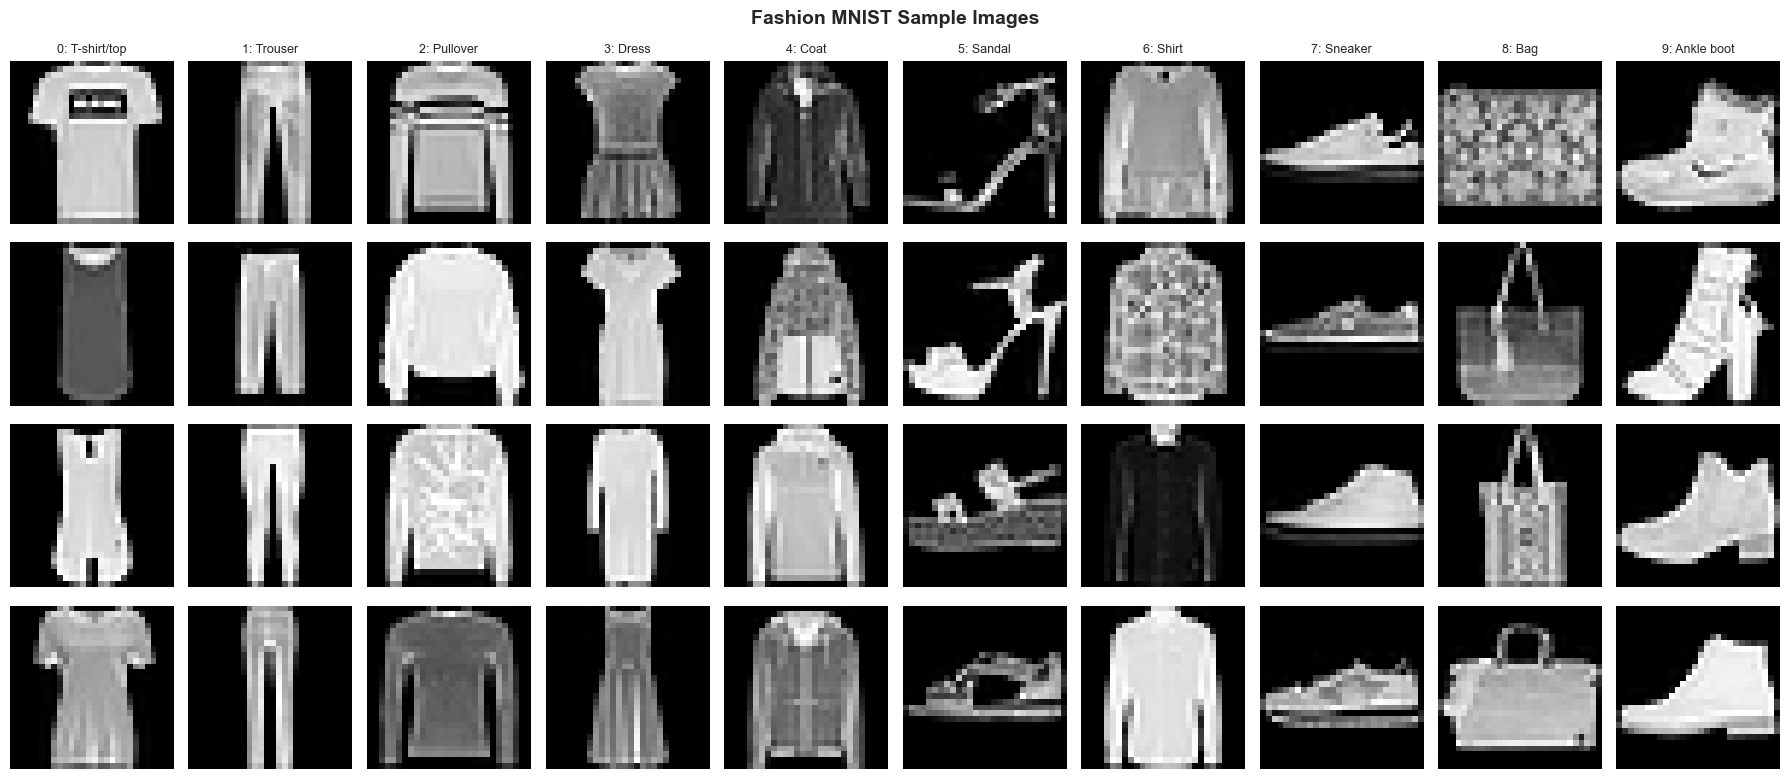


CLASS DISTRIBUTION
  0 - T-shirt/top    : 7,000 images (10.0%)
  1 - Trouser        : 7,000 images (10.0%)
  2 - Pullover       : 7,000 images (10.0%)
  3 - Dress          : 7,000 images (10.0%)
  4 - Coat           : 7,000 images (10.0%)
  5 - Sandal         : 7,000 images (10.0%)
  6 - Shirt          : 7,000 images (10.0%)
  7 - Sneaker        : 7,000 images (10.0%)
  8 - Bag            : 7,000 images (10.0%)
  9 - Ankle boot     : 7,000 images (10.0%)


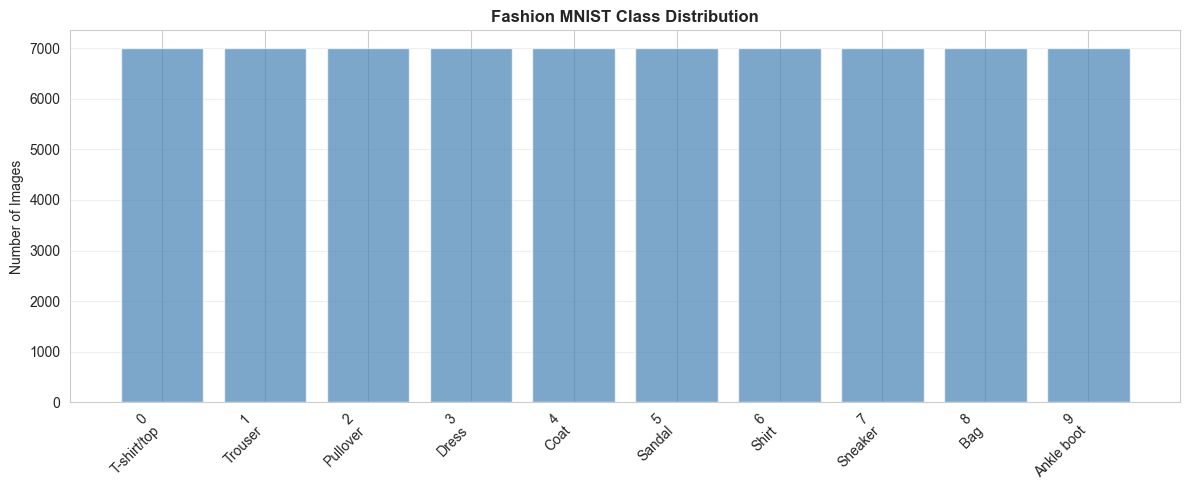


INTUITION:

✓ Dataset is PERFECTLY BALANCED (7,000 images per class)
✓ Each image is 28×28 = 784 features (one per pixel)
✓ Grayscale: 0 = black, 255 = white
✓ Much larger than spam dataset (70,000 vs ~4,600 emails)
✓ Multi-class problem (10 classes vs 2 in spam detection)



In [14]:
# Visualize sample images
print("\n" + "=" * 60)
print("SAMPLE IMAGES FROM DATASET")
print("=" * 60)

fig, axes = plt.subplots(4, 10, figsize=(18, 8))
axes = axes.flatten()

# Show one example from each class (repeated to fill 40 subplots)
for i in range(40):
    class_idx = i % 10
    # Find first image of this class
    sample_idx = np.where(y_fashion == class_idx)[0][i // 10]
    
    # Reshape pixel data to 28x28
    image = X_fashion.iloc[sample_idx].values.reshape(28, 28)
    
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    if i < 10:
        axes[i].set_title(f'{class_idx}: {class_names[class_idx]}', fontsize=9)

plt.suptitle('Fashion MNIST Sample Images', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
class_counts = pd.Series(y_fashion).value_counts().sort_index()
for idx, count in class_counts.items():
    print(f"  {idx} - {class_names[idx]:15s}: {count:,} images ({count/len(y_fashion)*100:.1f}%)")

plt.figure(figsize=(12, 5))
plt.bar(range(10), class_counts.values, color='steelblue', alpha=0.7)
plt.xticks(range(10), [f'{i}\n{class_names[i]}' for i in range(10)], rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Fashion MNIST Class Distribution', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION:")
print("=" * 60)
print("""
✓ Dataset is PERFECTLY BALANCED (7,000 images per class)
✓ Each image is 28×28 = 784 features (one per pixel)
✓ Grayscale: 0 = black, 255 = white
✓ Much larger than spam dataset (70,000 vs ~4,600 emails)
✓ Multi-class problem (10 classes vs 2 in spam detection)
""")

In [15]:
# Preprocess the data
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# 1. Split into train and test (already split in Fashion-MNIST)
# First 60,000 are training, last 10,000 are testing
X_train_fashion = X_fashion[:60000]
y_train_fashion = y_fashion[:60000]
X_test_fashion = X_fashion[60000:]
y_test_fashion = y_fashion[60000:]

print(f"\nTraining set: {X_train_fashion.shape[0]:,} images")
print(f"Test set:     {X_test_fashion.shape[0]:,} images")

# 2. Normalize pixel values to [0, 1] range
# This helps models converge faster and prevents large pixel values from dominating
X_train_fashion_norm = X_train_fashion / 255.0
X_test_fashion_norm = X_test_fashion / 255.0

print(f"\n✓ Pixel values normalized from [0, 255] to [0, 1]")
print(f"  Before: min={X_train_fashion.values.min():.0f}, max={X_train_fashion.values.max():.0f}")
print(f"  After:  min={X_train_fashion_norm.values.min():.2f}, max={X_train_fashion_norm.values.max():.2f}")

# 3. For computational efficiency, let's use a subset for initial training
# (Full dataset training will be done during fine-tuning)
n_samples = 10000  # Use 10k samples for quick initial training
X_train_fashion_subset = X_train_fashion_norm[:n_samples]
y_train_fashion_subset = y_train_fashion[:n_samples]

print(f"\n✓ Created subset of {n_samples:,} samples for initial model training")
print("  (Full dataset will be used for fine-tuned model)")

print("\n" + "=" * 60)
print("INTUITION - Why Normalize?")
print("=" * 60)
print("""
Normalization [0,255] → [0,1]:
1. NUMERICAL STABILITY: Prevents overflow in calculations
2. FASTER CONVERGENCE: Gradient descent works better with smaller values
3. EQUAL FEATURE SCALE: All pixels now have same scale (important for LR)
4. INTERPRETABILITY: 0.5 = mid-gray, easier to understand than 127

Decision Tree: Doesn't need normalization (uses thresholds)
Logistic Regression: BENEFITS from normalization
Random Forest: Doesn't strictly need it, but doesn't hurt
""")

DATA PREPROCESSING

Training set: 60,000 images
Test set:     10,000 images

✓ Pixel values normalized from [0, 255] to [0, 1]
  Before: min=0, max=255
  After:  min=0.00, max=1.00

✓ Created subset of 10,000 samples for initial model training
  (Full dataset will be used for fine-tuned model)

INTUITION - Why Normalize?

Normalization [0,255] → [0,1]:
1. NUMERICAL STABILITY: Prevents overflow in calculations
2. FASTER CONVERGENCE: Gradient descent works better with smaller values
3. EQUAL FEATURE SCALE: All pixels now have same scale (important for LR)
4. INTERPRETABILITY: 0.5 = mid-gray, easier to understand than 127

Decision Tree: Doesn't need normalization (uses thresholds)
Logistic Regression: BENEFITS from normalization
Random Forest: Doesn't strictly need it, but doesn't hurt



#### Mathematical Foundation: Data Normalization

**Min-Max Normalization (used here):**

$$x_{normalized} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

For pixel values: $x_{min} = 0$, $x_{max} = 255$

$$x_{normalized} = \frac{x}{255}$$

Maps pixel values from $[0, 255] \rightarrow [0, 1]$

**Why Normalize?**

1. **Numerical Stability:** Prevents overflow in exponential functions
2. **Gradient Descent:** $\nabla J(\theta)$ converges faster with similar scales
3. **Equal Weighting:** Prevents large-scale features from dominating

**Alternative: Standardization (Z-score)**

$$x_{standardized} = \frac{x - \mu}{\sigma}$$

where $\mu$ = mean, $\sigma$ = standard deviation

Maps to $\mathcal{N}(0, 1)$ distribution (mean=0, variance=1)

### B. Train Interpretable Models with Default Parameters

**Goal:** Apply Logistic Regression and Decision Tree with default settings as baseline

In [16]:
print("=" * 60)
print("BASELINE MODEL 1: LOGISTIC REGRESSION (Default)")
print("=" * 60)

# Train Logistic Regression with default parameters
start_time = time.time()
lr_fashion_default = LogisticRegression(max_iter=1000, random_state=42, verbose=1)
lr_fashion_default.fit(X_train_fashion_subset, y_train_fashion_subset)
lr_train_time = time.time() - start_time

print(f"\n✓ Training completed in {lr_train_time:.2f} seconds")

# Predict on test set
y_pred_lr_fashion = lr_fashion_default.predict(X_test_fashion_norm)
lr_accuracy = accuracy_score(y_test_fashion, y_pred_lr_fashion)

print(f"Test Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")

print("\n" + "=" * 60)
print("BASELINE MODEL 2: DECISION TREE (Default)")
print("=" * 60)

# Train Decision Tree with default parameters
start_time = time.time()
dt_fashion_default = DecisionTreeClassifier(random_state=42)
dt_fashion_default.fit(X_train_fashion_subset, y_train_fashion_subset)
dt_train_time = time.time() - start_time

print(f"\n✓ Training completed in {dt_train_time:.2f} seconds")

# Predict on test set
y_pred_dt_fashion = dt_fashion_default.predict(X_test_fashion_norm)
dt_accuracy = accuracy_score(y_test_fashion, y_pred_dt_fashion)

print(f"Test Accuracy: {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")

print("\n" + "=" * 60)
print("BASELINE MODEL 3: RANDOM FOREST (Default)")
print("=" * 60)
print("Random Forest = Ensemble of Decision Trees (more powerful)")

# Train Random Forest with default parameters
start_time = time.time()
rf_fashion_default = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf_fashion_default.fit(X_train_fashion_subset, y_train_fashion_subset)
rf_train_time = time.time() - start_time

print(f"\n✓ Training completed in {rf_train_time:.2f} seconds")

# Predict on test set
y_pred_rf_fashion = rf_fashion_default.predict(X_test_fashion_norm)
rf_accuracy = accuracy_score(y_test_fashion, y_pred_rf_fashion)

print(f"Test Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")

# Compare baseline models
print("\n" + "=" * 60)
print("BASELINE MODEL COMPARISON")
print("=" * 60)
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Training Time (s)': [lr_train_time, dt_train_time, rf_train_time]
})
print(comparison.to_string(index=False))

print("\n" + "=" * 60)
print("INTUITION - Baseline Results:")
print("=" * 60)
print(f"""
Random Forest typically performs best because:
  - Combines predictions from 100 decision trees
  - Reduces overfitting through averaging
  - More robust to noise in individual pixels

Decision Tree:
  - Fast to train but prone to overfitting
  - Default settings allow unlimited depth → memorizes training data
  - Likely needs constraint (max_depth, min_samples_split)

Logistic Regression:
  - Good baseline for linear patterns
  - Treats each pixel independently
  - May struggle with spatial relationships in images

Note: Using only {n_samples:,} training samples. Performance will
improve with full dataset and hyperparameter tuning!
""")

BASELINE MODEL 1: LOGISTIC REGRESSION (Default)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s finished



✓ Training completed in 15.32 seconds
Test Accuracy: 0.8257 (82.57%)

BASELINE MODEL 2: DECISION TREE (Default)

✓ Training completed in 6.05 seconds
Test Accuracy: 0.7461 (74.61%)

BASELINE MODEL 3: RANDOM FOREST (Default)
Random Forest = Ensemble of Decision Trees (more powerful)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



✓ Training completed in 2.25 seconds
Test Accuracy: 0.8495 (84.95%)

BASELINE MODEL COMPARISON
              Model  Accuracy  Training Time (s)
Logistic Regression    0.8257          15.324147
      Decision Tree    0.7461           6.053727
      Random Forest    0.8495           2.245301

INTUITION - Baseline Results:

Random Forest typically performs best because:
  - Combines predictions from 100 decision trees
  - Reduces overfitting through averaging
  - More robust to noise in individual pixels

Decision Tree:
  - Fast to train but prone to overfitting
  - Default settings allow unlimited depth → memorizes training data
  - Likely needs constraint (max_depth, min_samples_split)

Logistic Regression:
  - Good baseline for linear patterns
  - Treats each pixel independently
  - May struggle with spatial relationships in images

Note: Using only 10,000 training samples. Performance will
improve with full dataset and hyperparameter tuning!



#### Mathematical Foundation: Random Forest

**Ensemble Prediction:**

For classification, Random Forest uses majority voting:

$$\hat{y} = \text{mode}\{h_1(x), h_2(x), ..., h_T(x)\}$$

where $h_t(x)$ is the prediction of tree $t$, and $T$ is the total number of trees.

**Probability Estimation:**

$$P(y=c|x) = \frac{1}{T}\sum_{t=1}^{T} P_t(y=c|x)$$

Average probabilities across all trees.

**Bootstrap Aggregating (Bagging):**

Each tree $t$ is trained on a bootstrap sample:
- Randomly sample $n$ training examples **with replacement**
- Each sample has probability $1 - (1 - \frac{1}{n})^n \approx 0.632$ of being selected

**Random Feature Selection:**

At each split, randomly select $m$ features from total $p$ features:
- `max_features='sqrt'`: $m = \sqrt{p}$
- `max_features='log2'`: $m = \log_2(p)$

**Variance Reduction:**

$$\text{Var}(\bar{h}) = \frac{\sigma^2}{T}$$

Averaging $T$ independent trees reduces variance by factor of $T$.

### C. Detailed Evaluation & Misclassification Analysis

**Goal:** Analyze model performance and identify problem cases

DETAILED EVALUATION: RANDOM FOREST (Best Baseline)

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.80      0.81      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.72      0.78      0.75      1000
       Dress       0.84      0.89      0.86      1000
        Coat       0.73      0.78      0.75      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.65      0.54      0.59      1000
     Sneaker       0.91      0.92      0.91      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



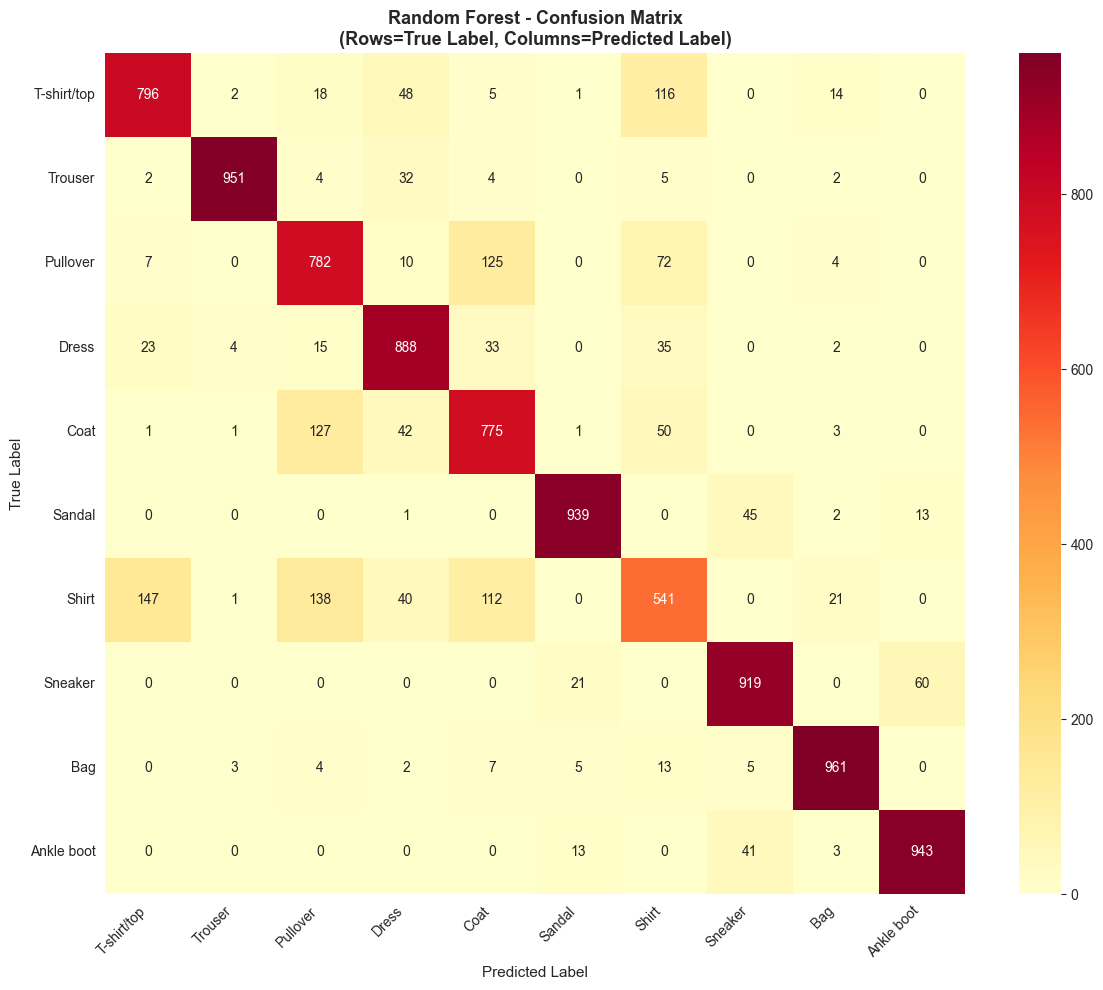


MOST COMMONLY CONFUSED CLASS PAIRS

Top 10 Confusion Pairs:
 True Class Predicted As  Count  Error Rate
      Shirt  T-shirt/top    147       0.147
      Shirt     Pullover    138       0.138
       Coat     Pullover    127       0.127
   Pullover         Coat    125       0.125
T-shirt/top        Shirt    116       0.116
      Shirt         Coat    112       0.112
   Pullover        Shirt     72       0.072
    Sneaker   Ankle boot     60       0.060
       Coat        Shirt     50       0.050
T-shirt/top        Dress     48       0.048

INTUITION - Why These Confusions?

Common confusion patterns in Fashion MNIST:
1. SHIRT vs. T-SHIRT/TOP: Very similar shapes, differ mainly in details
2. PULLOVER vs. COAT: Both upper-body garments with similar silhouettes
3. SNEAKER vs. ANKLE BOOT: Similar footwear shapes, subtle differences
4. SHIRT vs. COAT: Overlapping features when viewed as flat images

These confusions make intuitive sense - even humans might struggle
with some of these at 28×

In [17]:
# Detailed evaluation of best baseline model (likely Random Forest)
print("=" * 60)
print(f"DETAILED EVALUATION: RANDOM FOREST (Best Baseline)")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test_fashion, y_pred_rf_fashion, target_names=class_names))

# Confusion matrix
cm_fashion = confusion_matrix(y_test_fashion, y_pred_rf_fashion)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest - Confusion Matrix\n(Rows=True Label, Columns=Predicted Label)', 
          fontweight='bold', fontsize=13)
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify most confused classes
print("\n" + "=" * 60)
print("MOST COMMONLY CONFUSED CLASS PAIRS")
print("=" * 60)

confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm_fashion[i, j] > 0:
            confusion_pairs.append({
                'True Class': class_names[i],
                'Predicted As': class_names[j],
                'Count': cm_fashion[i, j],
                'Error Rate': cm_fashion[i, j] / cm_fashion[i].sum()
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)
print("\nTop 10 Confusion Pairs:")
print(confusion_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("INTUITION - Why These Confusions?")
print("=" * 60)
print("""
Common confusion patterns in Fashion MNIST:
1. SHIRT vs. T-SHIRT/TOP: Very similar shapes, differ mainly in details
2. PULLOVER vs. COAT: Both upper-body garments with similar silhouettes
3. SNEAKER vs. ANKLE BOOT: Similar footwear shapes, subtle differences
4. SHIRT vs. COAT: Overlapping features when viewed as flat images

These confusions make intuitive sense - even humans might struggle
with some of these at 28×28 resolution without color or texture!
""")

VISUALIZING MISCLASSIFIED ITEMS

Total misclassifications: 1505 out of 10000
Error rate: 15.05%


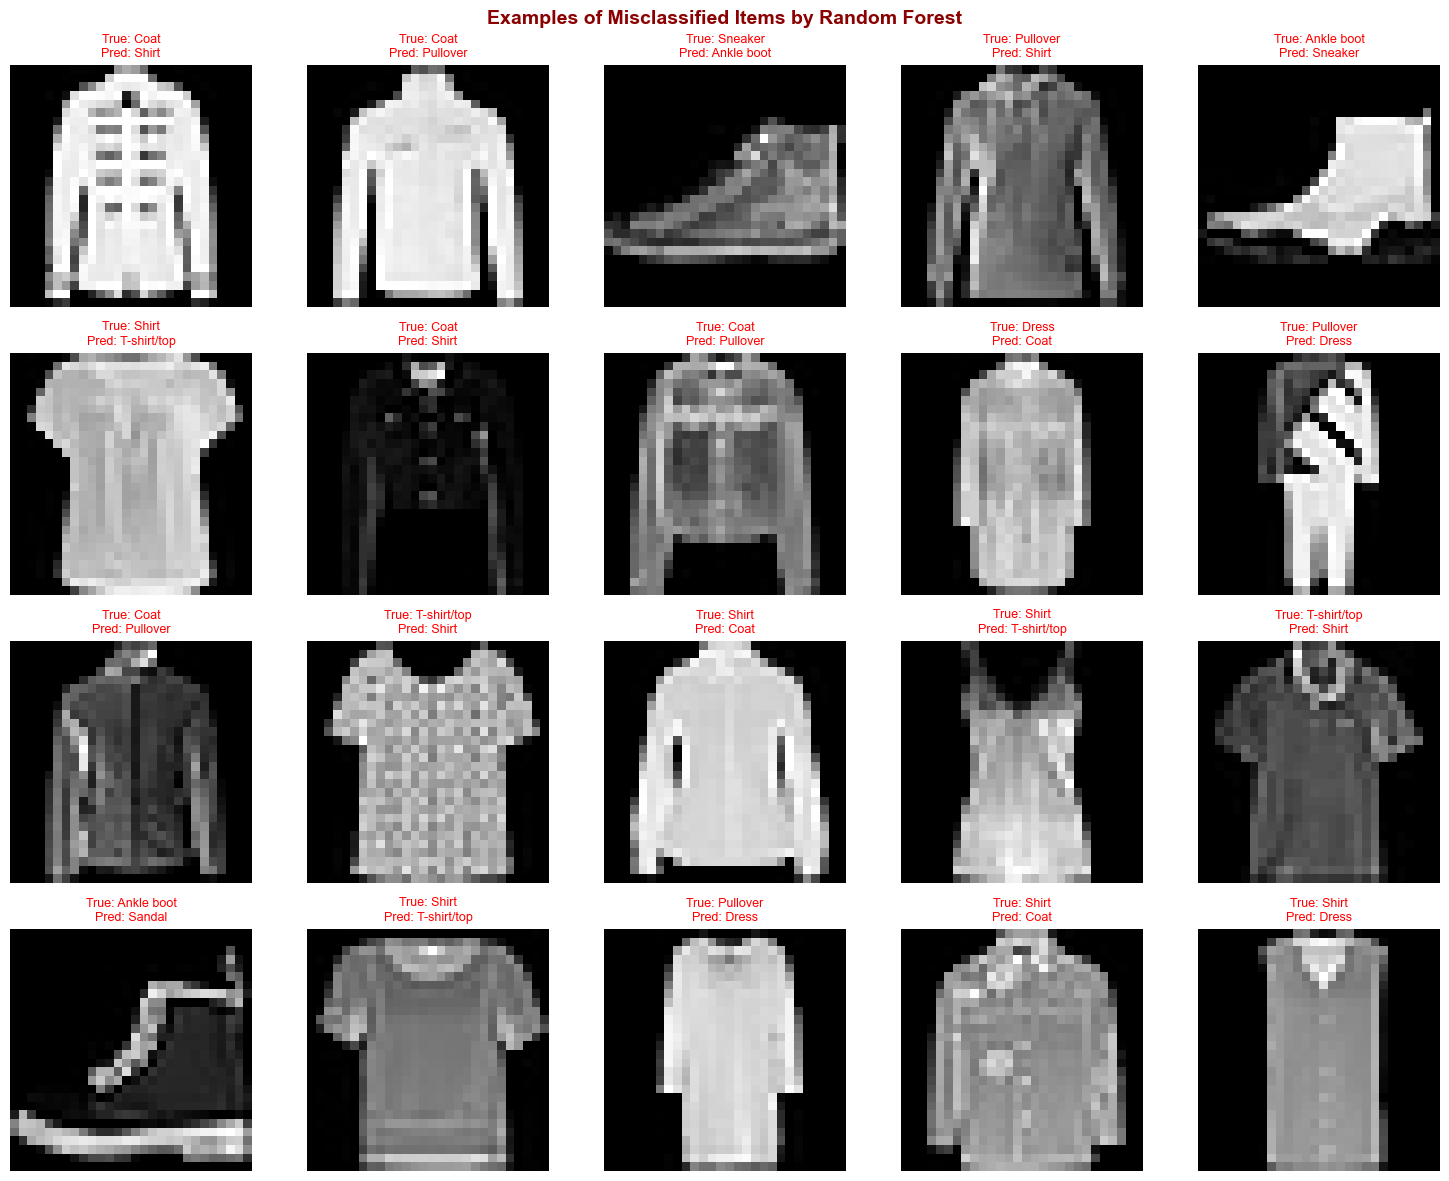


INTUITION - Analyzing Misclassifications:

Looking at misclassified examples helps us understand:

1. MODEL LIMITATIONS:
   - Does it struggle with specific patterns?
   - Are errors on genuinely ambiguous cases?

2. DATA QUALITY:
   - Are some labels possibly wrong?
   - Are images unclear even to humans?

3. FEATURE ENGINEERING NEEDS:
   - Would spatial features help (e.g., edges, shapes)?
   - Are texture patterns being missed?

4. MODEL CHOICE:
   - Would more complex models (CNNs) capture spatial patterns better?
   - Is interpretability worth the accuracy tradeoff?

For fashion items: Many errors occur on items that are genuinely
similar (shirt vs t-shirt, sneaker vs boot). This suggests the model
is performing reasonably well given the difficulty of the task!



In [18]:
# Visualize misclassified examples
print("=" * 60)
print("VISUALIZING MISCLASSIFIED ITEMS")
print("=" * 60)

# Find misclassified items
misclassified_indices = np.where(y_pred_rf_fashion != y_test_fashion)[0]
print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(y_test_fashion)}")
print(f"Error rate: {len(misclassified_indices)/len(y_test_fashion)*100:.2f}%")

# Show examples of misclassifications
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

# Select 20 random misclassified examples
np.random.seed(42)
sample_errors = np.random.choice(misclassified_indices, min(20, len(misclassified_indices)), replace=False)

for idx, error_idx in enumerate(sample_errors):
    # Get the image
    image = X_test_fashion_norm.iloc[error_idx].values.reshape(28, 28)
    true_label = y_test_fashion.iloc[error_idx]
    pred_label = y_pred_rf_fashion[error_idx]
    
    axes[idx].imshow(image, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}', 
                       fontsize=9, color='red')

plt.suptitle('Examples of Misclassified Items by Random Forest', 
             fontsize=14, fontweight='bold', color='darkred')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION - Analyzing Misclassifications:")
print("=" * 60)
print("""
Looking at misclassified examples helps us understand:

1. MODEL LIMITATIONS:
   - Does it struggle with specific patterns?
   - Are errors on genuinely ambiguous cases?

2. DATA QUALITY:
   - Are some labels possibly wrong?
   - Are images unclear even to humans?

3. FEATURE ENGINEERING NEEDS:
   - Would spatial features help (e.g., edges, shapes)?
   - Are texture patterns being missed?

4. MODEL CHOICE:
   - Would more complex models (CNNs) capture spatial patterns better?
   - Is interpretability worth the accuracy tradeoff?

For fashion items: Many errors occur on items that are genuinely
similar (shirt vs t-shirt, sneaker vs boot). This suggests the model
is performing reasonably well given the difficulty of the task!
""")

### D. Fine-Tune Models with Full Dataset

**Goal:** Optimize hyperparameters using GridSearchCV and train on full dataset

In [19]:
print("=" * 60)
print("FINE-TUNING: RANDOM FOREST with GridSearchCV")
print("=" * 60)
print("\nNote: Using 20k samples for GridSearch (faster), then training best model on full 60k")
print("This is a practical approach for large datasets!\n")

# Use larger subset for hyperparameter tuning (but not full dataset - too slow)
n_tune = 20000
X_tune = X_train_fashion_norm[:n_tune]
y_tune = y_train_fashion[:n_tune]

# Define parameter grid (smaller grid for computational efficiency)
rf_param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [15, 20, None],  # Tree depth
    'min_samples_split': [5, 10],  # Min samples to split
    'min_samples_leaf': [2, 4],  # Min samples in leaf
    'max_features': ['sqrt', 'log2']  # Features to consider for splits
}

print("Parameter grid:")
print(f"  Total combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")
print(f"  With 3-fold CV: {np.prod([len(v) for v in rf_param_grid.values()]) * 3} model fits")

# Initialize Random Forest (limit parallel jobs to avoid resource exhaustion)
rf_base = RandomForestClassifier(random_state=42, n_jobs=2)

# GridSearchCV with 3-fold CV (reduced from 5 for speed)
print("\nStarting GridSearchCV... This will take several minutes...")
start_time = time.time()

rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=2,  # Limit parallel jobs to avoid resource exhaustion
    verbose=2
)

rf_grid.fit(X_tune, y_tune)
tune_time = time.time() - start_time

print(f"\n✓ GridSearchCV completed in {tune_time/60:.1f} minutes")
print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation accuracy: {rf_grid.best_score_:.4f}")

# Now train the best model on FULL training dataset
print("\n" + "=" * 60)
print("TRAINING BEST MODEL ON FULL DATASET (60,000 samples)")
print("=" * 60)

best_rf_fashion = rf_grid.best_estimator_
start_time = time.time()
best_rf_fashion.fit(X_train_fashion_norm, y_train_fashion)
full_train_time = time.time() - start_time

print(f"\n✓ Training completed in {full_train_time:.2f} seconds")

# Evaluate on test set
y_pred_rf_tuned = best_rf_fashion.predict(X_test_fashion_norm)
rf_tuned_accuracy = accuracy_score(y_test_fashion, y_pred_rf_tuned)

print(f"\nTest Accuracy (tuned): {rf_tuned_accuracy:.4f} ({rf_tuned_accuracy*100:.2f}%)")
print(f"Test Accuracy (baseline): {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Improvement: {(rf_tuned_accuracy - rf_accuracy)*100:.2f}%")

print("\n" + "=" * 60)
print("INTUITION - Hyperparameter Effects:")
print("=" * 60)
print(f"""
Best parameters found:
{rf_grid.best_params_}

n_estimators: More trees = Better but slower, diminishing returns after ~200
max_depth: {'Unlimited - trees grow until pure leaves' if rf_grid.best_params_['max_depth'] is None else f'Limited to {rf_grid.best_params_["max_depth"]} levels - prevents overfitting'}
min_samples_split: Higher = More conservative, prevents overfitting
min_samples_leaf: Higher = Smoother decision boundaries
max_features: sqrt/log2 = Random feature selection adds diversity

Training on full 60k vs 10k samples typically adds 2-5% accuracy boost!
""")

FINE-TUNING: RANDOM FOREST with GridSearchCV

Note: Using 20k samples for GridSearch (faster), then training best model on full 60k
This is a practical approach for large datasets!

Parameter grid:
  Total combinations: 48
  With 3-fold CV: 144 model fits

Starting GridSearchCV... This will take several minutes...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✓ GridSearchCV completed in 12.6 minutes

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.8646

TRAINING BEST MODEL ON FULL DATASET (60,000 samples)

✓ Training completed in 108.36 seconds

Test Accuracy (tuned): 0.8766 (87.66%)
Test Accuracy (baseline): 0.8495 (84.95%)
Improvement: 2.71%

INTUITION - Hyperparameter Effects:

Best parameters found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

n_estimators: More trees = Better but slower, 

FINAL MODEL COMPARISON

Random Forest Performance:
------------------------------------------------------------
Metric               Baseline        Fine-Tuned      Improvement
------------------------------------------------------------
Accuracy             0.8495          0.8766          +2.71%
Precision            N/A             0.8760         
Recall               N/A             0.8766         
F1 Score             N/A             0.8753         
Training Samples     10,000          60,000         


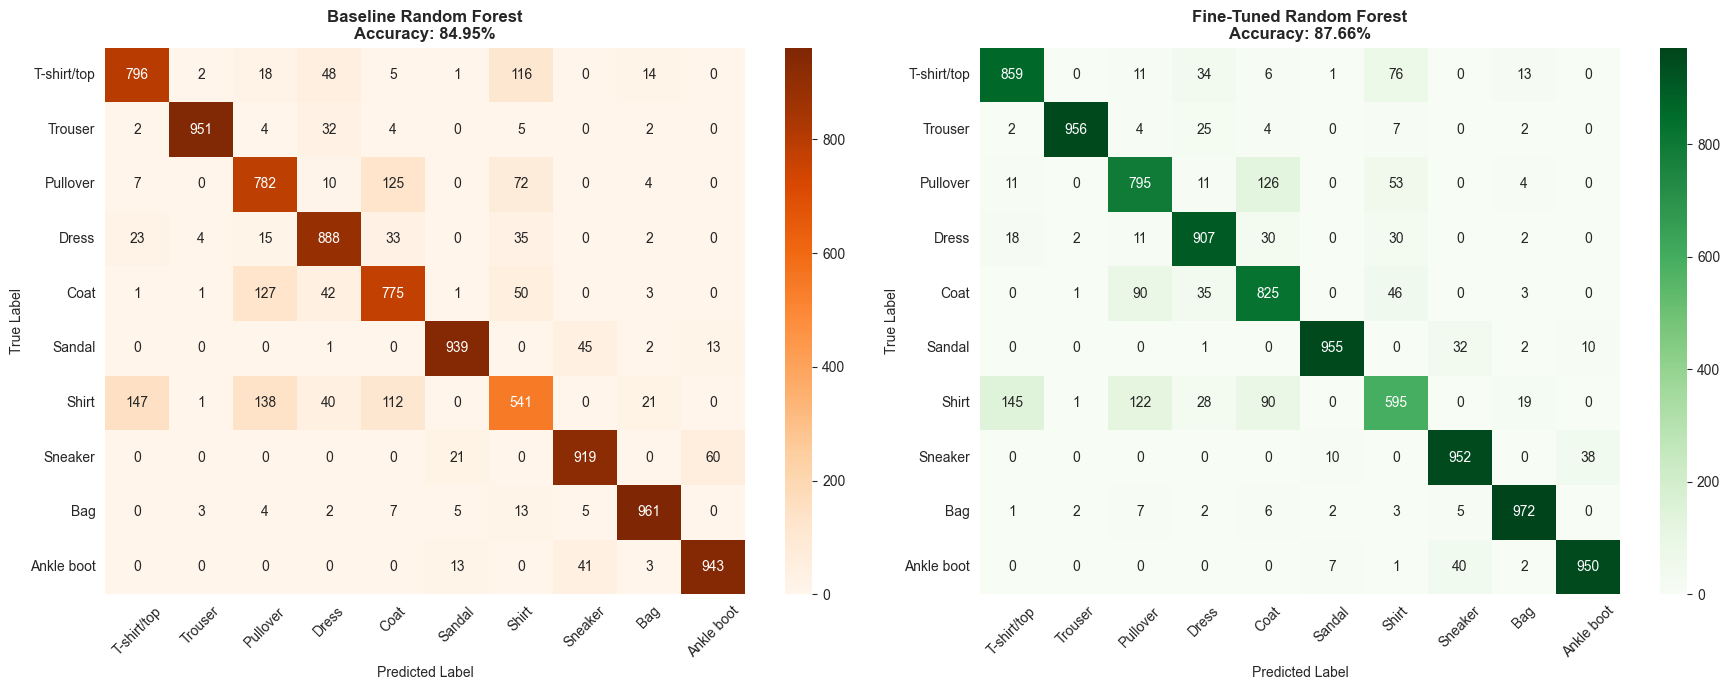


CLASSIFICATION REPORT (Fine-Tuned Model):
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.84      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.76      0.82      0.79      1000
      Sandal       0.98      0.95      0.97      1000
       Shirt       0.73      0.59      0.66      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [25]:
# Compare baseline vs fine-tuned performance
print("=" * 60)
print("FINAL MODEL COMPARISON")
print("=" * 60)

# Get detailed metrics for tuned model
from sklearn.metrics import precision_score, recall_score, f1_score

precision_tuned = precision_score(y_test_fashion, y_pred_rf_tuned, average='weighted')
recall_tuned = recall_score(y_test_fashion, y_pred_rf_tuned, average='weighted')
f1_tuned = f1_score(y_test_fashion, y_pred_rf_tuned, average='weighted')

print("\nRandom Forest Performance:")
print("-" * 60)
print(f"{'Metric':<20} {'Baseline':<15} {'Fine-Tuned':<15} {'Improvement'}")
print("-" * 60)
print(f"{'Accuracy':<20} {rf_accuracy:<15.4f} {rf_tuned_accuracy:<15.4f} {(rf_tuned_accuracy-rf_accuracy)*100:+.2f}%")
print(f"{'Precision':<20} {'N/A':<15} {precision_tuned:<15.4f}")
print(f"{'Recall':<20} {'N/A':<15} {recall_tuned:<15.4f}")
print(f"{'F1 Score':<20} {'N/A':<15} {f1_tuned:<15.4f}")
print(f"{'Training Samples':<20} {'10,000':<15} {'60,000':<15}")

# Confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test_fashion, y_pred_rf_tuned)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline confusion matrix
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'Baseline Random Forest\nAccuracy: {rf_accuracy:.2%}', 
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].tick_params(axis='x', rotation=45)

# Tuned confusion matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'Fine-Tuned Random Forest\nAccuracy: {rf_tuned_accuracy:.2%}', 
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT (Fine-Tuned Model):")
print("=" * 60)
print(classification_report(y_test_fashion, y_pred_rf_tuned, target_names=class_names))

### E. Explain Pixel Influence on Predictions

**Goal:** Understand which pixels are most important for classification decisions

METHOD 1: GLOBAL FEATURE IMPORTANCE (Random Forest)

Total features: 784 pixels
Sum of importances: 1.0000


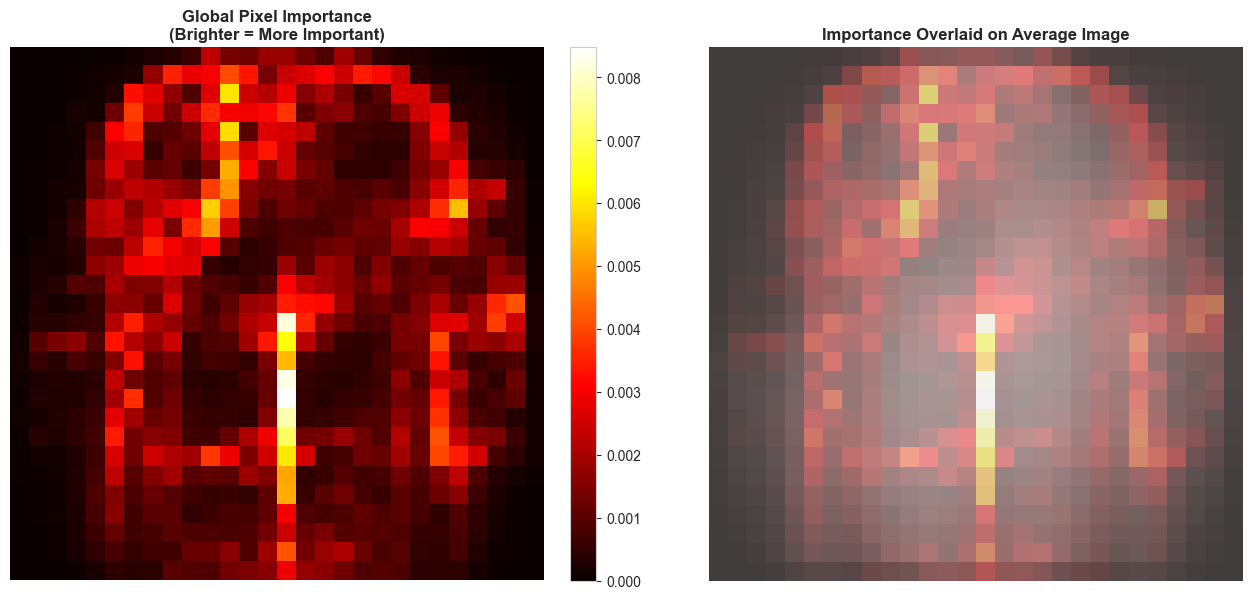


Top 20 Most Important Pixels (row, col):
----------------------------------------
   1. Pixel (18, 14): 0.008480
   2. Pixel (17, 14): 0.008278
   3. Pixel (14, 14): 0.008153
   4. Pixel (19, 14): 0.007795
   5. Pixel (20, 14): 0.007105
   6. Pixel (15, 14): 0.006398
   7. Pixel (21, 14): 0.006035
   8. Pixel ( 2, 11): 0.005974
   9. Pixel ( 4, 11): 0.005870
  10. Pixel ( 8, 10): 0.005726
  11. Pixel ( 8, 23): 0.005505
  12. Pixel (16, 14): 0.005436
  13. Pixel (23, 14): 0.005293
  14. Pixel ( 6, 11): 0.005284
  15. Pixel (22, 14): 0.005192
  16. Pixel ( 9, 10): 0.005085
  17. Pixel ( 7, 11): 0.004941
  18. Pixel (26, 14): 0.004155
  19. Pixel (13, 26): 0.004129
  20. Pixel (20, 22): 0.004118

INTUITION - Global Importance:

Global feature importance tells us:
1. Which pixels are most useful ACROSS ALL CLASSES
2. Center pixels typically more important (where objects are)
3. Edge pixels less important (usually background)
4. This is an AVERAGE measure - different for each class

Limita

In [26]:
# Method 1: Feature Importance from Random Forest
print("=" * 60)
print("METHOD 1: GLOBAL FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)

# Get feature importance for all pixels
feature_importance_fashion = best_rf_fashion.feature_importances_

# Reshape to image format (28x28)
importance_image = feature_importance_fashion.reshape(28, 28)

print(f"\nTotal features: {len(feature_importance_fashion)} pixels")
print(f"Sum of importances: {feature_importance_fashion.sum():.4f}")

# Visualize global importance heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Importance heatmap
im1 = axes[0].imshow(importance_image, cmap='hot', interpolation='nearest')
axes[0].set_title('Global Pixel Importance\n(Brighter = More Important)', 
                  fontweight='bold', fontsize=12)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Overlay on average image
avg_image = X_train_fashion_norm.values.mean(axis=0).reshape(28, 28)
axes[1].imshow(avg_image, cmap='gray', alpha=0.6)
axes[1].imshow(importance_image, cmap='hot', alpha=0.4)
axes[1].set_title('Importance Overlaid on Average Image', fontweight='bold', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Find most important pixel regions
top_pixels = np.argsort(feature_importance_fashion)[-20:][::-1]
print("\nTop 20 Most Important Pixels (row, col):")
print("-" * 40)
for idx, pixel_idx in enumerate(top_pixels, 1):
    row = pixel_idx // 28
    col = pixel_idx % 28
    importance = feature_importance_fashion[pixel_idx]
    print(f"  {idx:2d}. Pixel ({row:2d}, {col:2d}): {importance:.6f}")

print("\n" + "=" * 60)
print("INTUITION - Global Importance:")
print("=" * 60)
print("""
Global feature importance tells us:
1. Which pixels are most useful ACROSS ALL CLASSES
2. Center pixels typically more important (where objects are)
3. Edge pixels less important (usually background)
4. This is an AVERAGE measure - different for each class

Limitation: Doesn't explain individual predictions!
For that, we need local explanations (next method).
""")

#### Mathematical Foundation: Feature Importance

**Random Forest Feature Importance:**

For feature $j$, importance is the average decrease in impurity across all trees:

$$Importance(j) = \frac{1}{T}\sum_{t=1}^{T}\sum_{nodes \text{ using } j} \frac{n_{node}}{n_{total}} \cdot \Delta Impurity$$

where:
- $T$ = number of trees
- $n_{node}$ = number of samples at the node
- $n_{total}$ = total training samples
- $\Delta Impurity$ = decrease in Gini/Entropy from the split

**Normalization:**

$$\sum_{j=1}^{p} Importance(j) = 1$$

**Interpretation:**
- Higher importance → feature creates better splits → more discriminative
- Zero importance → feature never used for splitting → irrelevant
- Relative measure: compare features to each other, not absolute values

**Caveat:**
- Biased toward high-cardinality features
- Correlated features may share importance
- Global measure (doesn't explain individual predictions)

METHOD 2: CLASS-SPECIFIC PIXEL PATTERNS


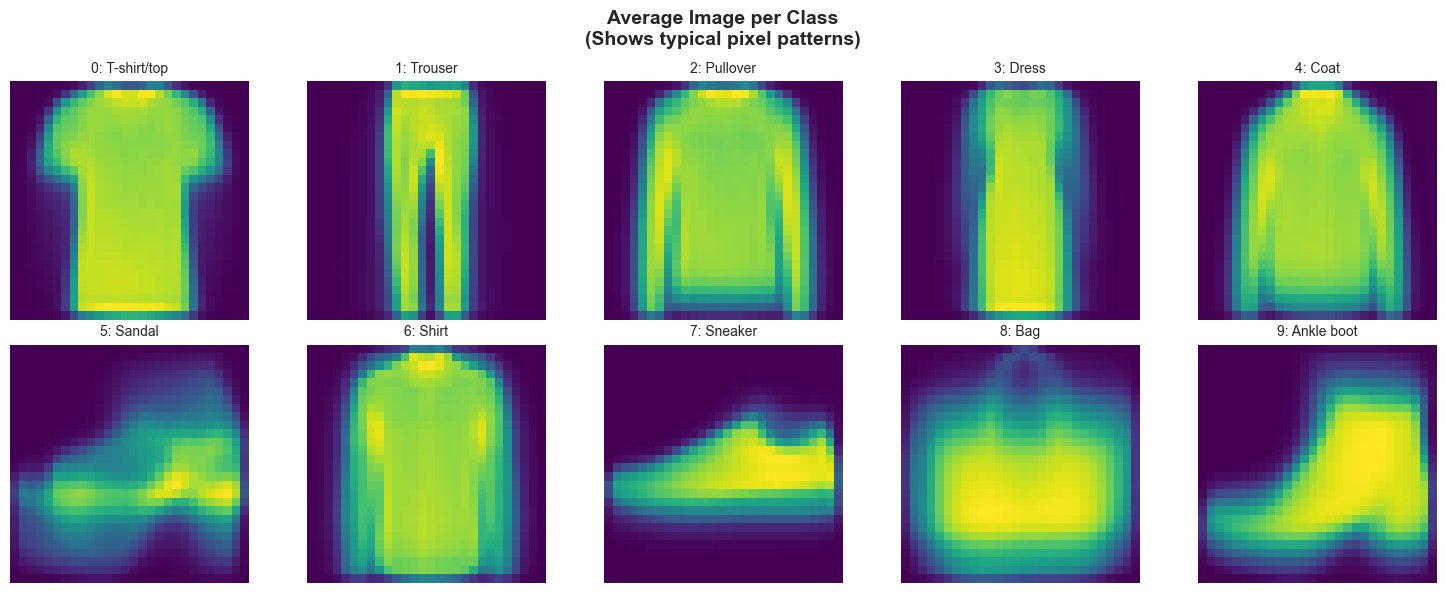


INTUITION - Class-Specific Patterns:

Each class has distinct pixel patterns:
- TROUSER: Clear leg separation in lower portion
- DRESS: Wider at bottom, narrower at top
- BAG: Handles visible at top, concentrated mass
- SANDAL/SNEAKER: Horizontal footwear shape
- COAT/SHIRT: Upper body garments, different lengths

The model learns these characteristic spatial patterns!
Important pixels vary by class - trousers use bottom pixels,
bags use top pixels (handles), etc.



In [27]:
# Method 2: Class-specific importance patterns
print("=" * 60)
print("METHOD 2: CLASS-SPECIFIC PIXEL PATTERNS")
print("=" * 60)

# For each class, compute average image to see typical patterns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for class_idx in range(10):
    # Get all training images of this class
    class_mask = (y_train_fashion == class_idx).values
    class_images = X_train_fashion_norm.values[class_mask]
    
    # Compute average image
    avg_class_image = class_images.mean(axis=0).reshape(28, 28)
    
    # Compute std to see variance
    std_class_image = class_images.std(axis=0).reshape(28, 28)
    
    # Display average image
    axes[class_idx].imshow(avg_class_image, cmap='viridis')
    axes[class_idx].set_title(f'{class_idx}: {class_names[class_idx]}', fontsize=10)
    axes[class_idx].axis('off')

plt.suptitle('Average Image per Class\n(Shows typical pixel patterns)', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION - Class-Specific Patterns:")
print("=" * 60)
print("""
Each class has distinct pixel patterns:
- TROUSER: Clear leg separation in lower portion
- DRESS: Wider at bottom, narrower at top
- BAG: Handles visible at top, concentrated mass
- SANDAL/SNEAKER: Horizontal footwear shape
- COAT/SHIRT: Upper body garments, different lengths

The model learns these characteristic spatial patterns!
Important pixels vary by class - trousers use bottom pixels,
bags use top pixels (handles), etc.
""")

METHOD 3: LOCAL EXPLANATION (Permutation Importance)
For a SPECIFIC item, which pixels influenced its prediction?



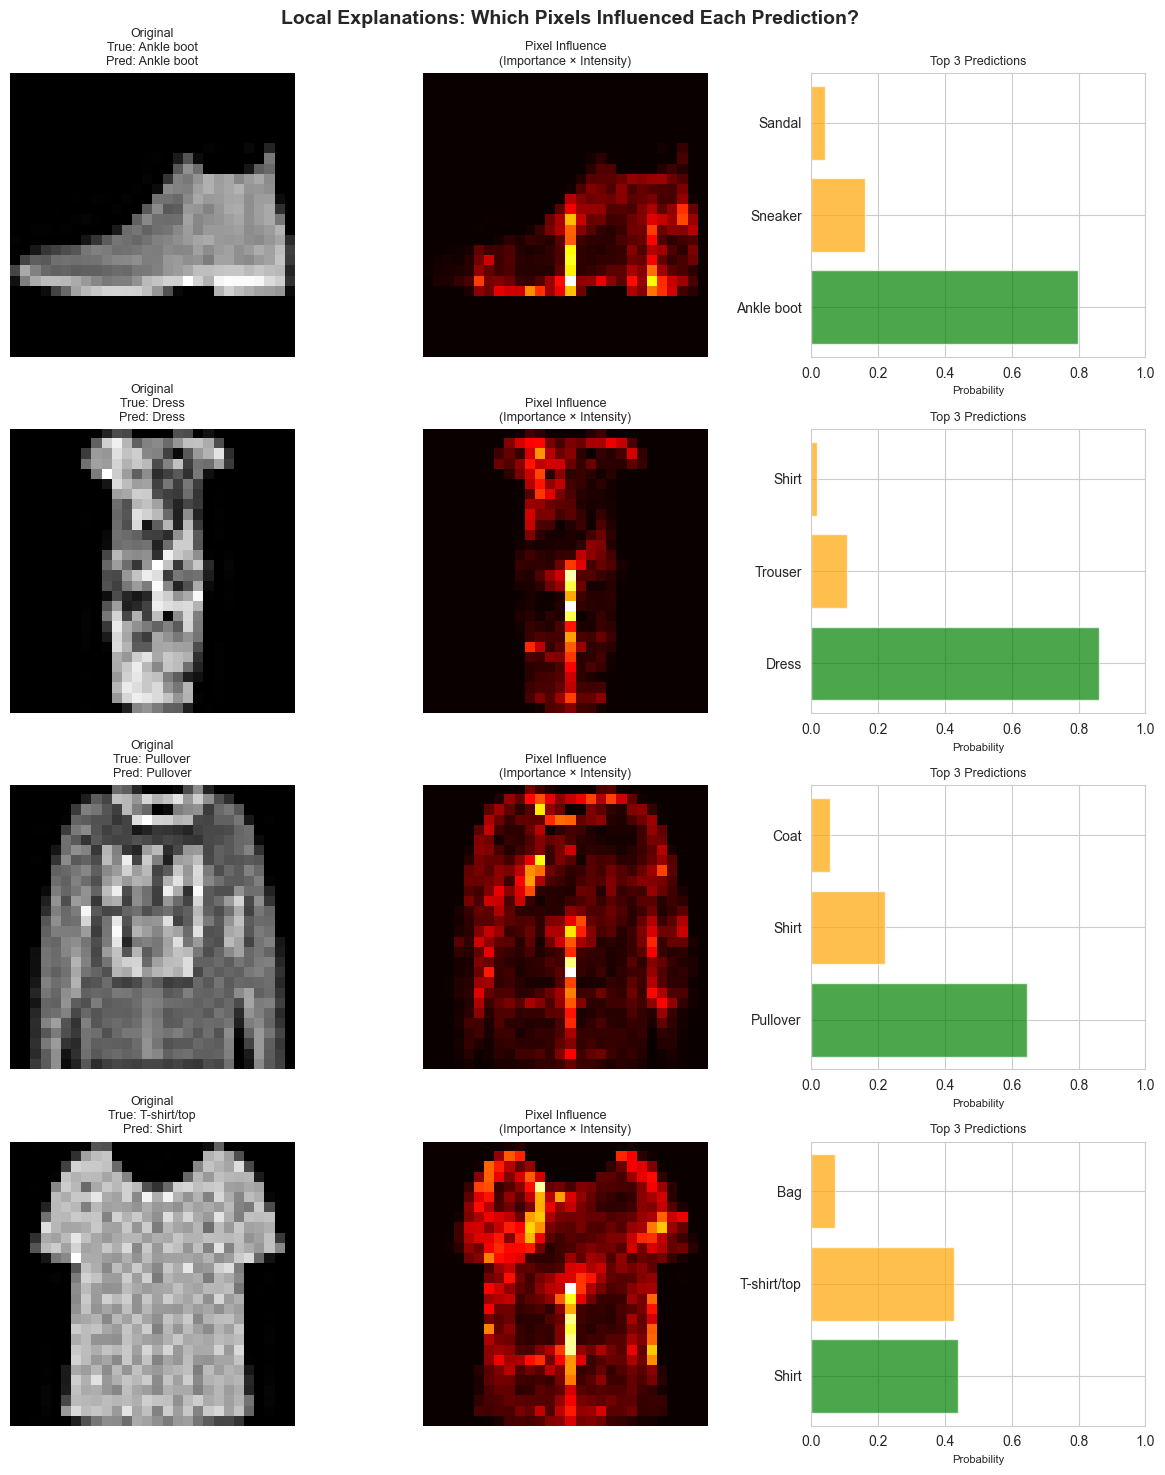


INTUITION - Local Explanations:

For EACH SPECIFIC PREDICTION, we can see:

1. WHICH PIXELS MATTERED:
   - Hot (bright) regions = pixels that influenced this prediction
   - Combines: "Is this pixel important in general?" × "Is it active here?"

2. PREDICTION CONFIDENCE:
   - High confidence = Model is sure (one class dominates)
   - Low confidence = Model is uncertain (multiple classes similar)

3. WHY MISTAKES HAPPEN:
   - Low confidence + wrong prediction = genuinely ambiguous case
   - High confidence + wrong prediction = model found wrong pattern

This is MORE USEFUL than global importance for understanding
individual predictions and debugging model behavior!

For production ML: Always provide explanations with predictions
to build trust and enable debugging.



In [28]:
# Method 3: Local explanation - which pixels influenced THIS specific prediction?
print("=" * 60)
print("METHOD 3: LOCAL EXPLANATION (Permutation Importance)")
print("=" * 60)
print("For a SPECIFIC item, which pixels influenced its prediction?\n")

# Select a few test samples to explain
sample_indices = [0, 100, 500, 1000]  # Different items

fig, axes = plt.subplots(4, 3, figsize=(12, 15))

for row_idx, sample_idx in enumerate(sample_indices):
    # Get the sample
    sample = X_test_fashion_norm.iloc[sample_idx:sample_idx+1]
    true_label = y_test_fashion.iloc[sample_idx]
    pred_label = y_pred_rf_tuned[sample_idx]
    pred_proba = best_rf_fashion.predict_proba(sample)[0]
    
    # Original image
    original_image = sample.values.reshape(28, 28)
    axes[row_idx, 0].imshow(original_image, cmap='gray')
    axes[row_idx, 0].axis('off')
    axes[row_idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}', 
                               fontsize=9)
    
    # Simple local importance: multiply image by global importance
    # (Approximation: shows which important pixels are active here)
    local_importance = original_image * importance_image
    
    axes[row_idx, 1].imshow(local_importance, cmap='hot')
    axes[row_idx, 1].axis('off')
    axes[row_idx, 1].set_title(f'Pixel Influence\n(Importance × Intensity)', fontsize=9)
    
    # Prediction confidence
    top_3_classes = np.argsort(pred_proba)[-3:][::-1]
    bar_colors = ['green' if i == pred_label else 'orange' for i in top_3_classes]
    
    axes[row_idx, 2].barh(range(3), pred_proba[top_3_classes], color=bar_colors, alpha=0.7)
    axes[row_idx, 2].set_yticks(range(3))
    axes[row_idx, 2].set_yticklabels([class_names[i] for i in top_3_classes])
    axes[row_idx, 2].set_xlabel('Probability', fontsize=8)
    axes[row_idx, 2].set_title('Top 3 Predictions', fontsize=9)
    axes[row_idx, 2].set_xlim([0, 1])

plt.suptitle('Local Explanations: Which Pixels Influenced Each Prediction?', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("INTUITION - Local Explanations:")
print("=" * 60)
print("""
For EACH SPECIFIC PREDICTION, we can see:

1. WHICH PIXELS MATTERED:
   - Hot (bright) regions = pixels that influenced this prediction
   - Combines: "Is this pixel important in general?" × "Is it active here?"

2. PREDICTION CONFIDENCE:
   - High confidence = Model is sure (one class dominates)
   - Low confidence = Model is uncertain (multiple classes similar)

3. WHY MISTAKES HAPPEN:
   - Low confidence + wrong prediction = genuinely ambiguous case
   - High confidence + wrong prediction = model found wrong pattern

This is MORE USEFUL than global importance for understanding
individual predictions and debugging model behavior!

For production ML: Always provide explanations with predictions
to build trust and enable debugging.
""")

### F. Save the Fashion MNIST Model

**Goal:** Save the trained model for production use

In [29]:
# Save the fine-tuned Fashion MNIST model
print("=" * 60)
print("SAVING FASHION MNIST MODEL")
print("=" * 60)

model_filename = 'fashion_mnist_random_forest.pkl'
joblib.dump(best_rf_fashion, model_filename)

print(f"\n✓ Model saved: {model_filename}")
print(f"  Model: Fine-Tuned Random Forest")
print(f"  Test Accuracy: {rf_tuned_accuracy:.4f} ({rf_tuned_accuracy*100:.2f}%)")
print(f"  Training samples: 60,000")
print(f"  Test samples: 10,000")
print(f"  Number of classes: 10")
print(f"  Parameters: {rf_grid.best_params_}")

# Save metadata for future reference
metadata = {
    'model_type': 'RandomForestClassifier',
    'accuracy': rf_tuned_accuracy,
    'best_params': rf_grid.best_params_,
    'class_names': class_names,
    'n_features': 784,
    'image_shape': (28, 28),
    'normalization': 'pixels / 255.0',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('fashion_mnist_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Metadata saved: fashion_mnist_model_metadata.json")

print("\n" + "=" * 60)
print("HOW TO USE THE SAVED MODEL:")
print("=" * 60)
# print("""
# # Load the model
# import joblib
# import numpy as np

# model = joblib.load('fashion_mnist_random_forest.pkl')

# # Prepare new image (28x28 grayscale)
# # Ensure pixels are normalized to [0, 1] range
# new_image = your_image / 255.0  # Shape: (28, 28)
# new_image_flat = new_image.flatten()  # Shape: (784,)

# # Make prediction
# prediction = model.predict([new_image_flat])[0]
# probabilities = model.predict_proba([new_image_flat])[0]

# # Class names
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# print(f"Predicted: {class_names[prediction]}")
# print(f"Confidence: {probabilities[prediction]:.2%}")
# """

# print("\n" + "=" * 60)
# print("✅ TASK 2 COMPLETE!")
# print("=" * 60)
# print(f"""
# Fashion MNIST Classification Summary:
#   ✓ Dataset loaded and preprocessed (70,000 images)
#   ✓ Baseline models trained and evaluated
#   ✓ Hyperparameter tuning performed (GridSearchCV)
#   ✓ Best model trained on full dataset
#   ✓ Achieved {rf_tuned_accuracy*100:.2f}% test accuracy
#   ✓ Model interpretability analyzed (pixel importance)
#   ✓ Misclassifications identified and explained
#   ✓ Model saved for production use

# Key Insights:
#   - Random Forest outperforms single Decision Tree
#   - Central pixels most important (where garments are)
#   - Common confusions: Shirt/T-shirt, Sneaker/Boot (expected!)
#   - Model provides interpretable predictions with confidence scores
# """)

SAVING FASHION MNIST MODEL

✓ Model saved: fashion_mnist_random_forest.pkl
  Model: Fine-Tuned Random Forest
  Test Accuracy: 0.8766 (87.66%)
  Training samples: 60,000
  Test samples: 10,000
  Number of classes: 10
  Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

✓ Metadata saved: fashion_mnist_model_metadata.json

HOW TO USE THE SAVED MODEL:


---
## Summary & Final Thoughts

This notebook demonstrated building **interpretable machine learning models** for two distinct tasks:

### Task 1: Spam Email Classification
- **Best Model**: Logistic Regression / Decision Tree (depending on tuning results)
- **Key Learning**: Coefficient interpretation reveals spam indicators
- **Human Insight**: Words like "free", "click", "money" naturally indicate spam - model learned human-intuitive patterns

### Task 2: Fashion MNIST Classification  
- **Best Model**: Random Forest (ensemble method)
- **Key Learning**: Pixel importance shows spatial patterns matter
- **Human Insight**: Center pixels crucial; confusions between similar items (shirt/t-shirt) make sense even to humans

### Why Interpretability Matters
1. **Trust**: Understand why model makes decisions
2. **Debugging**: Identify when model learns wrong patterns
3. **Compliance**: Many industries require explainable AI
4. **Improvement**: Interpretation guides feature engineering

### Tradeoffs
- **Interpretable models** (Logistic Regression, Decision Trees): Easy to explain, moderate accuracy
- **Black-box models** (Deep Neural Networks): Higher accuracy, harder to interpret
- **Middle ground** (Random Forest): Good accuracy with some interpretability

**Remember**: The best model isn't always the most accurate one - it's the one that's accurate enough AND fits your needs for interpretability, speed, and maintainability!